## 本程序调用构建好的网络，对读取的test数据集进行预测，并对结果进行分析

## test数据集目前在“datasets”文件夹下，模型在“nn_train”文件夹内，输出包括预测的结果和结果分析，为csv和txt文件，都在“pre_analysis”中

last update: 2021.10/08

contacts：zhaohf@ihep.ac.cn

contributor: zhaohf@ihep.ac.cn, yuqj@ihep.ac.cn

# 配置环境

通用模块构建
  检查python、Tensorflow等模块的版本，确保搭建的框架能够稳定运行。

In [1]:
import os
import sys
assert sys.version_info >= (3, 5)
#
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#
# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

from tensorflow import keras
#from tensorflow.keras import optimizers
#
# pydot_ng and graphviz are for tf.keras.utils.plot_model
# note that installing pydot_ng is 'pydot-ng'
# note that 在windows下不可以使用pip install graphviz 下载graphviz安装包，
# 要去https://graphviz.gitlab.io/下载windows版本的安装包，安装好之后在环境变量中添加对应的路径即可！！！
import graphviz
import pydot
import pydot_ng
#
import time
import math

输出导入模板的版本。

In [2]:
print('python version:',sys.version)
print('TensorFlow version:',tf.__version__)
print('numpy version:',np.__version__)
print('panda version:',pd.__version__)
print('matplotlib version:',mpl.__version__)
print('graphviz version:',graphviz.__version__)
print('pydot version:',pydot.__version__)
print('pydot_ng version:',pydot_ng.__version__)
#
#print('time version:',time.__version__)
#print('math version:',math.__version__)

python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
TensorFlow version: 2.5.0
numpy version: 1.19.5
panda version: 1.2.4
matplotlib version: 3.3.4
graphviz version: 0.17
pydot version: 1.4.2
pydot_ng version: 2.0.0


# 参数设置

## 配置输入文件夹

设置ML模型的文件夹路径和文件名

In [3]:
dir_model = 'nn_train'
file_saved_model = 'au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11.h5'

设置需要预测的文件的路径和文件名

In [4]:
dir_data = 'datasets'
file_feature_test = 'Au_chi_test.txt'
file_label_test = 'Au_cn_test.txt'

## 配置输出文件夹

设置预测结果和预测分析所放置的文件夹

In [5]:
dir_ana = 'pre_analysis'

设置label标签，用于后面模型训练、绘图

In [6]:
label_index = 'CN'

# 部分函数模块

## 设置绘图格式和保存图片的模块

  确保绘制的图形美观、能保存下来。

In [7]:
# To plot pretty figures
# %matplotlib具体作用是调用matplotlib.pyplot的绘图函数plot()进行绘图时，
# 或生成一个figure画布时，可以直接在你的python console里面生成图像。
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)   # matplotlib.rc 什么意思没找到
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
#PROJECT_ROOT_DIR = "."
#path_images = os.path.join(PROJECT_ROOT_DIR, "images")
#os.makedirs(path_images, exist_ok=True)
path_images = os.path.join(os.curdir, dir_ana)
os.makedirs(path_images, exist_ok=True)

def save_fig(fig_id, path_fig = path_images, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_fig, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 将一个整数序列（含有多个连续零）改造成只包含少量零的序列，供作图使用

In [8]:
def list_modify(start, end, list0):
    """
    删除list0(start, end)中0元素连续超过三个的部分，只保留有非零周围的0，返回修正过的列表和列表各元素所在的序号
    这里假设list0[start]和list0[end]都不为0。
    """
    list_index = []
    list_modify = []
    if start == end:
        list_index = [start]
        list_modify = [list0[start]]
        return list_index, list_modify
    if start > end:
        print(f"\n{'#'*10:10}Warning!! Error list!")
        print(f"{' ':10}Start({start}) > End({end}) !")
#        sys.exit(0)
        return [], []
#
    for i in range(start,end):    #注意，这里估计不统计list0[end]因为它不为零
        j = list0[i] + list0[i+1]
        if j != 0:
            list_index.append(i)
            list_modify.append(list0[i])
        else:
            k = list0[i] + list0[i-1]
            if k != 0:
                list_index.append(i)
                list_modify.append(list0[i])
    list_index.append(end)
    list_modify.append(list0[end])
    return list_index, list_modify

In [9]:
def list_modify_without0(start, end, list0):
    """
    删除list0(start, end)中所有0元素，返回修正过的列表和列表各元素所在的序号
    这里假设list0[start]和list0[end]都不为0。
    """
    list_index = []
    list_modify = []
    if start == end:
        list_index = [start]
        list_modify = [list0[start]]
        return list_index, list_modify
    if start > end:
        print(f"\n{'#'*10:10}Warning!! Error list!")
        print(f"{' ':10}Start({start}) > End({end}) !")
#        sys.exit(0)
        return [], []
#
    for i in range(start,end):    #注意，这里估计不统计list0[end]因为它不为零
        j = list0[i]
        if j != 0:
            list_index.append(i)
            list_modify.append(j)
    list_index.append(end)
    list_modify.append(list0[end])
    return list_index, list_modify

## 绘制每个单独CN的预测分布

函数解释：
matplotlib.pyplot.text(x, y, s, fontdict=None, withdash=False, **kwargs)

常用参数说明：

x，y：显示内容的坐标位置

s：显示内容

fontdict：一个定义s格式的dict

fontsize：字体大小

color：str or tuple, 设置字体颜色 ,单个字符候选项{‘b’, ‘g’, ‘r’, ‘c’, ‘m’, ‘y’, ‘k’, ‘w’}，也可以’black’,'red’等，tuple时用[0,1]之间的浮点型数据，RGB或者RGBA, 如: (0.1, 0.2, 0.5)、(0.1, 0.2, 0.5, 0.3)等

backgroundcolor：字体背景颜色

horizontalalignment(ha)：设置垂直对齐方式，可选参数：left,right,center

verticalalignment(va)：设置水平对齐方式 ，可选参数 ： ‘center’ , ‘top’ , ‘bottom’ ,‘baseline’

rotation(旋转角度)：可选参数为:vertical,horizontal 也可以为数字

alpha：透明度，参数值0至1之间
————————————————
版权声明：本文为CSDN博主「Test_Box」的原创文章，遵循CC 4.0 BY-SA版权协议，转载请附上原文出处链接及本声明。
原文链接：https://blog.csdn.net/joson1234567890/article/details/103835674

In [10]:
# 绘制各个cluster的CR统计图
def plot_pre_cn(x0, y, xmin, xmax, step, digit, path, file):
    """
    绘制每个单独CN的预测分布
    x0：真实值
    y: 列表，其第i个元素为所有样本预测值位于区间[i*step, (i+1)*step)中的个数
    step: 间隔
    digit：自然数，用于给出绘制图中x轴数字的有效位数，如果步长为0.1，则为1，若步长为0.05， 则为2
    path：图的保存路径
    file：图的名称（不包含后缀）    
    """
#
# 为了绘图中的x轴上显示更为清晰，设置step_plot，让其的整数倍显示数字
    step_plot = 1
# 设置一个很小的数
    trivial = 0.00001
#
    #fig = plt.figure(num=1, figsize=(15, 8),dpi=80) #开启一个窗口，同时设置大小，分辨率
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
#
    a = round(x0/step)
    x_min = min(xmin,a)
    x_max = max(xmax,a-1)
    len_x = x_max - x_min + 1
#
    rotation = 0
    fontsize = 10
    if len_x >= 12:
        rotation = 30
        if len_x >= 20 :
            fontsize = 8
            if len_x >= 25:
                fontsize = 6
#
    x_index = np.around(np.arange(x_min,x_max+1)*step,digit)
    y_index = np.array(y[x_min:x_max+1])
#    print(f"y[{x_min} : {x_max+1}] = {y[x_min:x_max+1]}")
#    print(f"y_index = {y_index}")
#
    bar_width = step #定义一个数字代表每个独立柱的宽度
#
    rects1 = ax1.bar(x_index, y_index, width=bar_width,align='edge',alpha=0.5, color='yellow',edgecolor='red',label=file)
# 将y_index的值标注在柱状图上，但又不显示为0的数字，因此准备新建一个列表，让其内容与y_index一样，不过0的地方改为无字符''
#
    y_text = []
    for i in list(y_index):
        if i == 0 :
            y_text.append('')
        else:
            y_text.append(i)
#
    for a,b,c in zip(x_index,y_index,y_text):
#        plt.text(a+step/2, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=fontsize)
        plt.text(a+step/2, b+0.05, c, ha='center', va= 'bottom',fontsize=fontsize)
#
#    plt.xticks(x_index + bar_width/2, x_data) #x轴刻度线
    ax1.set_xticks(np.append(x_index,round((x_max+1)*step,digit)))
# 设置x轴上的label。原则是0.5的倍数的，都显示；非零的bar的两边，都显示数字。
    x_ticklabels = []
    for i, a in enumerate(list(x_index)):
        if abs((a/step_plot)-int((a+trivial)/step_plot)) < trivial:
            x_ticklabels.append(a)
        elif y_index[i] != 0:
            x_ticklabels.append(a)
        elif y_index[i]+y_index[i-1] != 0:
            x_ticklabels.append(a)
        else:
            x_ticklabels.append('')
    x_ticklabels.append(round((x_max+1)*step,digit))
    ax1.set_xticklabels(np.array(x_ticklabels),rotation=rotation,fontsize=fontsize)
#
#    ax1.set_xlim(min(x0,xmin*step), max(x0,xmax*step))
    ax1.set_ylim(0, max(y)*1.15)
    ax1.set_xlabel('Predicted Coordinate Number')
    ax1.set_ylabel('Number')
    ax1.set_title(f"Prediction Performance for CN={x0}",fontsize=12)
#
    plt.vlines(x0, 0, max(y), colors="blue", linestyles="dashed", linewidth=2, label = label_index+f"={x0}")
#
#    plt.legend('upper right') #显示图例
    plt.legend(fontsize=fontsize) #显示图例
    plt.tight_layout() #自动控制图像外部边缘，此方法不能够很好的控制图像间的间隔
#
    save_fig(file,path)
    plt.close(fig)

In [11]:
# 绘制各个cluster的CR统计图
def plot_pre_cn_err(label, x0min, x0max, y, xmin, xmax, x_low, step, digit, path, file):
    """
    绘制每个单独CN的预测分布
    label : label值
    x0min, x0max：error最大最小值
    xmin, xmax : error落在区间的区间标号值
    x_low : error区间为0的真正标号
    y: 列表，其第i个元素为所有样本预测值位于区间[i*step, (i+1)*step)中的个数
    step: 间隔
    digit：自然数，用于给出绘制图中x轴数字的有效位数，如果步长为0.1，则为1，若步长为0.05， 则为2
    path：图的保存路径
    file：图的名称（不包含后缀）    
    """
#
# 为了绘图中的x轴上显示更为清晰，设置step_plot，让其的整数倍显示数字
    step_plot = 1
# 设置一个很小的数
    trivial = min(0.00001,step/100)
#
    #fig = plt.figure(num=1, figsize=(15, 8),dpi=80) #开启一个窗口，同时设置大小，分辨率
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
#
    a = -x_low
    x_min = min(xmin,a)
    x_max = max(xmax,a-1)
    len_x = x_max - x_min + 1
#
    rotation = 0
    fontsize = 10
    if len_x >= 12:
        rotation = 30
        if len_x >= 20 :
            fontsize = 8
            if len_x >= 25:
                fontsize = 6
#
    x_index = np.around((np.arange(x_min,x_max+1)+x_low)*step,digit)
    y_index = np.array(y[x_min:x_max+1])
#    print(label)
#    print(np.arange(x_min,x_max+1))
#    print(x_index)
#    print(f"y[{x_min} : {x_max+1}] = {y[x_min:x_max+1]}")
#    print(f"y_index = {y_index}")
#
    bar_width = step #定义一个数字代表每个独立柱的宽度
#
    rects1 = ax1.bar(x_index, y_index, width=bar_width,align='edge',alpha=0.5, color='yellow',edgecolor='red',label=file)
# 将y_index的值标注在柱状图上，但又不显示为0的数字，因此准备新建一个列表，让其内容与y_index一样，不过0的地方改为无字符''
#
    y_text = []
    for i in list(y_index):
        if i == 0 :
            y_text.append('')
        else:
            y_text.append(i)
#
    for a,b,c in zip(x_index,y_index,y_text):
#        plt.text(a+step/2, b+0.05, '%.0f' % b, ha='center', va= 'bottom',fontsize=fontsize)
        plt.text(a+step/2, b+0.05, c, ha='center', va= 'bottom',fontsize=fontsize)
#
#    plt.xticks(x_index + bar_width/2, x_data) #x轴刻度线
    ax1.set_xticks(np.append(x_index,round((x_max+1+x_low)*step,digit)))
# 设置x轴上的label。原则是0.5的倍数的，都显示；非零的bar的两边，都显示数字。
    x_ticklabels = []
    for i, a in enumerate(list(x_index)):
        if abs((a/step_plot)-int((a+trivial)/step_plot)) < trivial:
            x_ticklabels.append(a)
        elif y_index[i] != 0:
            x_ticklabels.append(a)
        elif y_index[i]+y_index[i-1] != 0:
            x_ticklabels.append(a)
        else:
            x_ticklabels.append('')
    x_ticklabels.append(round((x_max+1+x_low)*step,digit))
    ax1.set_xticklabels(np.array(x_ticklabels),rotation=rotation,fontsize=fontsize)
#
#    ax1.set_xlim(min(x0,xmin*step), max(x0,xmax*step))
    ax1.set_ylim(0, max(y)*1.15)
    ax1.set_xlabel('Predict CN error')
    ax1.set_ylabel('Number')
    ax1.set_title(f"Prediction Performance for CN={label}",fontsize=12)
#
    plt.vlines(x0min, 0, max(y), colors="green", linestyles="dashed", linewidth=1.5, label = 'error_min')
    plt.vlines(x0max, 0, max(y), colors="blue", linestyles="dashed", linewidth=1.5, label = 'error_max')
    plt.vlines(0, 0, max(y), colors="black", linestyles="dashed", linewidth=3, label = 'error=0')
#
#    plt.legend('upper right') #显示图例
    plt.legend(fontsize=fontsize) #显示图例
    plt.tight_layout() #自动控制图像外部边缘，此方法不能够很好的控制图像间的间隔
#
    save_fig(file,path)
    plt.close(fig)

# 正文

## 确定当前目录和工作目录

In [12]:
path = os.path.abspath(os.curdir)
path

'D:\\haifeng\\work_20210709\\ML+XAS\\code\\neural network module\\latest'

检查这些文件是否存在

In [13]:
path_dir_data = os.path.join(path,dir_data)
for file in (file_feature_test, file_label_test):
    path_file = os.path.join(path_dir_data,file)
#
# 检查csv是否存在，若不存在，报错
    exist = os.path.exists(path_file)
    if not exist:
        print()
        print(f"** Error!! cannot find file {file_data[i]} in directory {dir_data}! **")
        print()
        sys.exit()

## 数据导入

### 读取test文件，制成数据集。

In [14]:
import pandas as pd
path_file = os.path.join(path_dir_data,file_feature_test)
#   df.values, df.as_matrix() and np.array(df) all works.
data_df = pd.read_csv(path_file,header=None,delim_whitespace=True)
feature_test = data_df.values
#
path_file = os.path.join(path_dir_data,file_label_test)
#   df.values, df.as_matrix() and np.array(df) all works.
data_df = pd.read_csv(path_file,header=None,delim_whitespace=True)
label_test = data_df.values

In [15]:
print(feature_test.shape, label_test.shape)

(597, 400) (597, 1)


In [16]:
feature_test

array([[ 2.557644e-01,  2.537106e-01,  2.477222e-01, ..., -1.224513e-06,
        -1.189495e-06, -1.089308e-06],
       [ 8.617267e-02,  8.524817e-02,  8.253932e-02, ..., -4.987466e-07,
        -7.527434e-07, -9.162964e-07],
       [ 3.098491e-01,  3.075325e-01,  3.007803e-01, ..., -1.503519e-06,
        -1.751413e-06, -1.855771e-06],
       ...,
       [ 1.633016e-01,  1.616820e-01,  1.571817e-01, ..., -1.616210e-06,
        -1.438373e-06, -1.191754e-06],
       [ 2.649083e-01,  2.628461e-01,  2.568242e-01, ...,  5.872027e-07,
         7.930178e-07,  9.127764e-07],
       [ 2.487297e-01,  2.467340e-01,  2.409130e-01, ..., -2.460035e-06,
        -2.220299e-06, -1.854691e-06]])

In [17]:
label_test

array([[ 8],
       [ 8],
       [ 8],
       [ 7],
       [ 6],
       [12],
       [ 9],
       [13],
       [12],
       [ 8],
       [ 7],
       [14],
       [12],
       [ 6],
       [13],
       [12],
       [ 9],
       [ 5],
       [12],
       [12],
       [ 9],
       [ 8],
       [ 8],
       [ 8],
       [ 5],
       [12],
       [ 7],
       [13],
       [ 8],
       [ 8],
       [13],
       [12],
       [12],
       [ 8],
       [ 6],
       [14],
       [ 9],
       [ 7],
       [ 8],
       [12],
       [12],
       [ 7],
       [ 8],
       [ 9],
       [12],
       [12],
       [12],
       [ 8],
       [12],
       [12],
       [ 6],
       [ 6],
       [11],
       [12],
       [ 8],
       [ 6],
       [12],
       [ 6],
       [ 6],
       [ 7],
       [12],
       [ 9],
       [ 8],
       [ 4],
       [ 8],
       [ 6],
       [ 6],
       [ 8],
       [12],
       [12],
       [12],
       [ 6],
       [ 9],
       [12],
       [ 8],
       [10],
       [ 9],

设置网络训练参数值，输入数组维数

In [18]:
input_shape = feature_test.shape[1:]
input_shape

(400,)

## 模型导入

### 检查网络模型是否存在，若不存在，报错

In [19]:
path_model = os.path.join(path, dir_model)
path_saved_model = os.path.join(path_model, file_saved_model)
#
exist = os.path.exists(path_saved_model)
if exist:
    pass
else:
    print()
    print('** Error!! cannot find ANN file: ', file_saved_model)
    print()
    sys.exit()

In [20]:
model = keras.models.load_model(path_saved_model)

## 预测

In [21]:
loss_val = model.evaluate(feature_test, label_test)

19/19 [==============================] - 0s 835us/step - loss: 0.2560


上面给出的loss值，也是也是当时模型给出的标准（当时设为MSE）

### 查看预测结果

In [22]:
pre = model.predict(feature_test)
pre

array([[ 8.29563  ],
       [ 8.097859 ],
       [ 8.207412 ],
       [ 7.2415833],
       [ 6.0748353],
       [11.958113 ],
       [ 9.332053 ],
       [12.949848 ],
       [11.959579 ],
       [ 7.83174  ],
       [ 6.9943376],
       [14.322575 ],
       [11.719291 ],
       [ 6.188469 ],
       [12.900297 ],
       [12.050947 ],
       [ 9.033862 ],
       [ 4.7255807],
       [11.407785 ],
       [12.301664 ],
       [ 8.270692 ],
       [ 7.7772765],
       [ 7.974203 ],
       [ 7.7563434],
       [ 5.4848876],
       [11.873677 ],
       [ 6.926788 ],
       [13.071445 ],
       [ 7.7227836],
       [ 8.053186 ],
       [12.781484 ],
       [12.056599 ],
       [12.058729 ],
       [ 8.018773 ],
       [ 5.722935 ],
       [12.4701395],
       [ 9.336258 ],
       [ 6.730183 ],
       [ 8.257501 ],
       [12.4245615],
       [11.894618 ],
       [ 6.797836 ],
       [ 7.51546  ],
       [ 9.159556 ],
       [12.029825 ],
       [12.232824 ],
       [12.216371 ],
       [ 8.22

## 预测分析

### 总体计算

In [23]:
diff = pre - label_test
diff_abs = np.abs(diff)
diff2 = np.square(diff)     # = diff**2
pre_var_mean = np.mean(diff2)
pre_var_std = np.sqrt(pre_var_mean)     # = pre_var_mean**0.5
err = diff / label_test
err_abs = np.abs(err)

### 计算数据保存

#### 设置保存路径和文件名称

In [24]:
#dir_ana = 'pre_analysis'
path_ana_work = os.path.join(os.curdir, dir_ana)
os.makedirs(path_ana_work, exist_ok=True)

In [25]:
# 文件前缀
file_pre = os.path.splitext(os.path.basename(file_feature_test))[0] + '_' + os.path.splitext(os.path.basename(path_saved_model))[0]
file_pre

'Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11'

In [26]:
# 预测结果文件名和路径
file_pre_txt = file_pre + '_pre.txt'
file_pre_csv = file_pre + '_pre.csv'
path_pre_txt = os.path.join(path_ana_work,file_pre_txt)
path_pre_csv = os.path.join(path_ana_work,file_pre_csv)

In [27]:
# 预测分析文件名和路径
file_ana_txt  = file_pre + '_pre_analysis.txt'
path_ana_txt = os.path.join(path_ana_work,file_ana_txt)
path_ana_txt

'.\\pre_analysis\\Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_pre_analysis.txt'

In [28]:
# 单独配位的绘图文件夹
path_cn_work = os.path.join(path_ana_work, file_pre)
os.makedirs(path_cn_work, exist_ok=True)

#### 保存预测数据

##### 将预测结果保存到csv文件

In [29]:
import pandas as pd 
df = pd.DataFrame([label_test.flatten(),
                   pre.flatten(),   # pre.T[0] also works
                   diff.flatten(),
                   diff_abs.flatten(),
                   err.flatten(),
                   err_abs.flatten()]) 
df = df.transpose() 
head = [f'{label_index}_real',
        f'{label_index}_pre',
        f'{label_index}_diff',
        f'|{label_index}_diff|',
        f'{label_index}_err',
        f'|{label_index}_err|']
df.to_csv(path_pre_csv, index=False, header=head) 

##### 将本来值、预测值输出到txt文件中

In [30]:
fout = open(path_pre_txt,'w')
str_no = 'No.'
str_lab = 'Label'
str_pre = 'Predict'
str_diff = 'Diff'
str_diff_abs = '|Diff|'
str_err = 'Error'
str_err_abs = '|Error|'
#str_avg = 'Avg.'
#str_max = 'Max.'
#str_min = 'Min.'
#str_var = 'Var.(MSE)'
#str_std = 'Std.(RMES)'
# n_xx 是输出格式中各列的占位数
n_maxnd_label = 5                          # label的个数，如1万，则需要5位数
#n_no = max(n_maxnd_label,len(str_no),len(str_avg),len(str_max),len(str_min),len(str_var),len(str_std))
n_no = max(n_maxnd_label,len(str_no))
n_lab_after_dot = 1                        # label本身（如12.0）小数点后面位数
n_lab_before_dot = 2                        # label本身（如12.0）小数点前面位数
n_lab = max(n_lab_before_dot+1+n_lab_after_dot,len(str_lab))     #label不会是负数
n_pre_after_dot = 4
n_pre_before_dot = n_lab_before_dot
n_pre = max(n_pre_before_dot+1+n_pre_after_dot,len(str_pre))
n_diff = max(n_pre_before_dot+1+n_pre_after_dot+1,len(str_diff))   # 考虑负号
n_diff_abs = max(n_pre_before_dot+1+n_pre_after_dot,len(str_diff_abs))
n_err_after_dot = 3
n_err = max(n_err_after_dot+4+2+1,len(str_err))
n_err_abs = max(n_err_after_dot+4+2,len(str_err_abs))
#
print(f"{'*'*5:>5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5:>5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5:>5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5:>5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5:>5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5:>5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
print(f"\n{str_no:>{n_no}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}")
print(f"\n{str_no:>{n_no}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}", file=fout)
print(f"{'-'*(n_no+1+n_lab+1+n_pre+1+n_diff+1+n_diff_abs+1+n_err+1+n_err_abs)}")
print(f"{'-'*(n_no+1+n_lab+1+n_pre+1+n_diff+1+n_diff_abs+1+n_err+1+n_err_abs)}", file=fout)
for i in range(pre.size):
    print(f"{i+1:>{n_no}d} {label_test[i][0]:>{n_lab}.{n_lab_after_dot}f} {pre[i][0]:>{n_pre}.{n_pre_after_dot}f} {diff[i][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[i][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[i][0]:>{n_err}.{n_err_after_dot}E} {err_abs[i][0]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{i+1:>{n_no}d} {label_test[i][0]:>{n_lab}.{n_lab_after_dot}f} {pre[i][0]:>{n_pre}.{n_pre_after_dot}f} {diff[i][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[i][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[i][0]:>{n_err}.{n_err_after_dot}E} {err_abs[i][0]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#
fout.close()

***** Model   : nn_train/au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11.h5
***** Fearute : datasets/Au_chi_test.txt
***** Label   : datasets/Au_cn_test.txt
Total   : 597 data

  No. Label Predict     Diff  |Diff|      Error   |Error|
---------------------------------------------------------
    1   8.0  8.2956   0.2956  0.2956  3.695E-02 3.695E-02
    2   8.0  8.0979   0.0979  0.0979  1.223E-02 1.223E-02
    3   8.0  8.2074   0.2074  0.2074  2.593E-02 2.593E-02
    4   7.0  7.2416   0.2416  0.2416  3.451E-02 3.451E-02
    5   6.0  6.0748   0.0748  0.0748  1.247E-02 1.247E-02
    6  12.0 11.9581  -0.0419  0.0419 -3.491E-03 3.491E-03
    7   9.0  9.3321   0.3321  0.3321  3.689E-02 3.689E-02
    8  13.0 12.9498  -0.0502  0.0502 -3.858E-03 3.858E-03
    9  12.0 11.9596  -0.0404  0.0404 -3.368E-03 3.368E-03
   10   8.0  7.8317  -0.1683  0.1683 -2.103E-02 2.103E-02
   11   7.0  6.9943  -0.0057  0.0057 -8.089E-04 8.089E-04
   12  14.0 14.3226   0.3226  0.3226  2.304E-02 2.304E-02
   13  12.

#### 保存总体分析数据

##### 对预测值进行分析

In [31]:
attr_dict3 = {
    'diff_Max'               : np.max(diff),
    'diff_Min'               : np.min(diff),
    '|diff|_Mean(MAE)'       : np.mean(diff_abs),
    '|diff|_Max'             : np.max(diff_abs),
    '|diff|_Min'             : np.min(diff_abs),
    'pre_Var(MSE)'           : pre_var_mean,
    'pre_Std(RMSE)'          : pre_var_std,
    'Error_mean'             : np.mean(err),
    'Error_max'              : np.max(err),
    'Error_min'              : np.min(err),
    '|Error|_mean(MAPE)'     : np.mean(err_abs),
    '|Error|_max'            : np.max(err_abs),
    '|Error|_min'            : np.min(err_abs)
}

In [32]:
fout = open(path_ana_txt,'w')
print("Prediction:")
print("Prediction:",file=fout)
for key in attr_dict3.keys():
    print(f"  {key:<20}: {attr_dict3[key]:>10.7f}")
    print(f"  {key:<20}: {attr_dict3[key]:>10.7f}",file=fout)
fout.close()

Prediction:
  diff_Max            :  4.8695502
  diff_Min            : -2.4915724
  |diff|_Mean(MAE)    :  0.3021127
  |diff|_Max          :  4.8695502
  |diff|_Min          :  0.0006914
  pre_Var(MSE)        :  0.2559554
  pre_Std(RMSE)       :  0.5059203
  Error_mean          :  0.0112575
  Error_max           :  4.4555907
  Error_min           : -0.2561054
  |Error|_mean(MAPE)  :  0.0459057
  |Error|_max         :  4.4555907
  |Error|_min         :  0.0000576


##### 作为对照，在分析结果中给出label数据的情况

In [33]:
label_mean = np.mean(label_test)
label_diff = label_test - label_mean
label_diff_abs = np.abs(label_diff)
label_err = label_diff / label_test
label_err_abs = np.abs(label_err)

In [34]:
attr_dict2 = {
    'Mean'                   : label_mean,
    'Max'                    : np.max(label_test),
    'Min'                    : np.min(label_test),
    'diff_Max'               : np.max(label_diff),
    'diff_Min'               : np.min(label_diff),
    '|diff|_Mean'            : np.mean(label_diff_abs),
    '|diff|_Max'             : np.max(label_diff_abs),
    '|diff|_Min'             : np.min(label_diff_abs),
    'Var'                    : np.var(label_test),
    'Std'                    : np.std(label_test),
    'Error_mean'             : np.mean(label_err),
    'Error_max'              : np.max(label_err),
    'Error_min'              : np.min(label_err),
    '|Error|_mean'           : np.mean(label_err_abs),
    '|Error|_max'            : np.max(label_err_abs),
    '|Error|_min'            : np.min(label_err_abs),
    'Midd'                   : np.median(label_test)
}

In [35]:
fout = open(path_ana_txt,'a')
print("\nLabel Info:")
print("\nLabel Info:",file=fout)
for key in attr_dict2.keys():
    print(f"  {key:<15}: {attr_dict2[key]:>10.7f}")
    print(f"  {key:<15}: {attr_dict2[key]:>10.7f}",file=fout)
fout.close()


Label Info:
  Mean           :  9.1055276
  Max            : 15.0000000
  Min            :  1.0000000
  diff_Max       :  5.8944724
  diff_Min       : -8.1055276
  |diff|_Mean    :  2.2413575
  |diff|_Max     :  8.1055276
  |diff|_Min     :  0.1055276
  Var            :  6.6371051
  Std            :  2.5762580
  Error_mean     : -0.1060317
  Error_max      :  0.3929648
  Error_min      : -8.1055276
  |Error|_mean   :  0.2897209
  |Error|_max    :  8.1055276
  |Error|_min    :  0.0117253
  Midd           :  8.0000000


### 图形展示预测误差

#### 整体误差

In [36]:
def plot_PredictionError(ylim,ind=0):
    """
    """
#
    prediction_error = file_pre + "_prediction_error" + f"_{ind}"
    plt.plot(err, label = f'{label_index}')
    plt.xlabel('Test series')
    plt.ylabel('Error')
    plt.ylim(ylim)
    plt.legend(loc='upper left',fontsize=12)
    plt.title(f"{label_index} Prediction Error", fontsize=16)
    save_fig(prediction_error, path_ana_work)

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_error_0


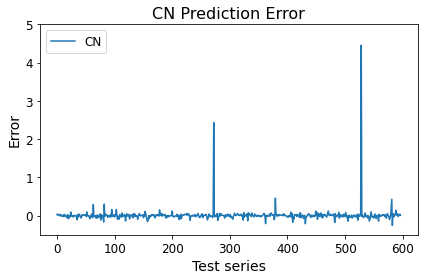

In [37]:
plot_PredictionError([-0.5,5],ind=0)

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_error_2


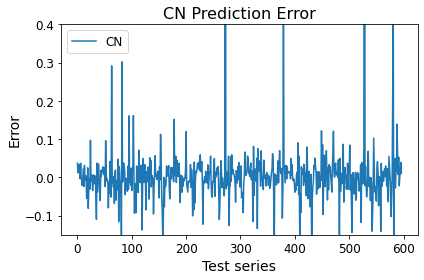

In [38]:
plot_PredictionError([-0.15,0.4],ind=2)

#### 直接比较

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN


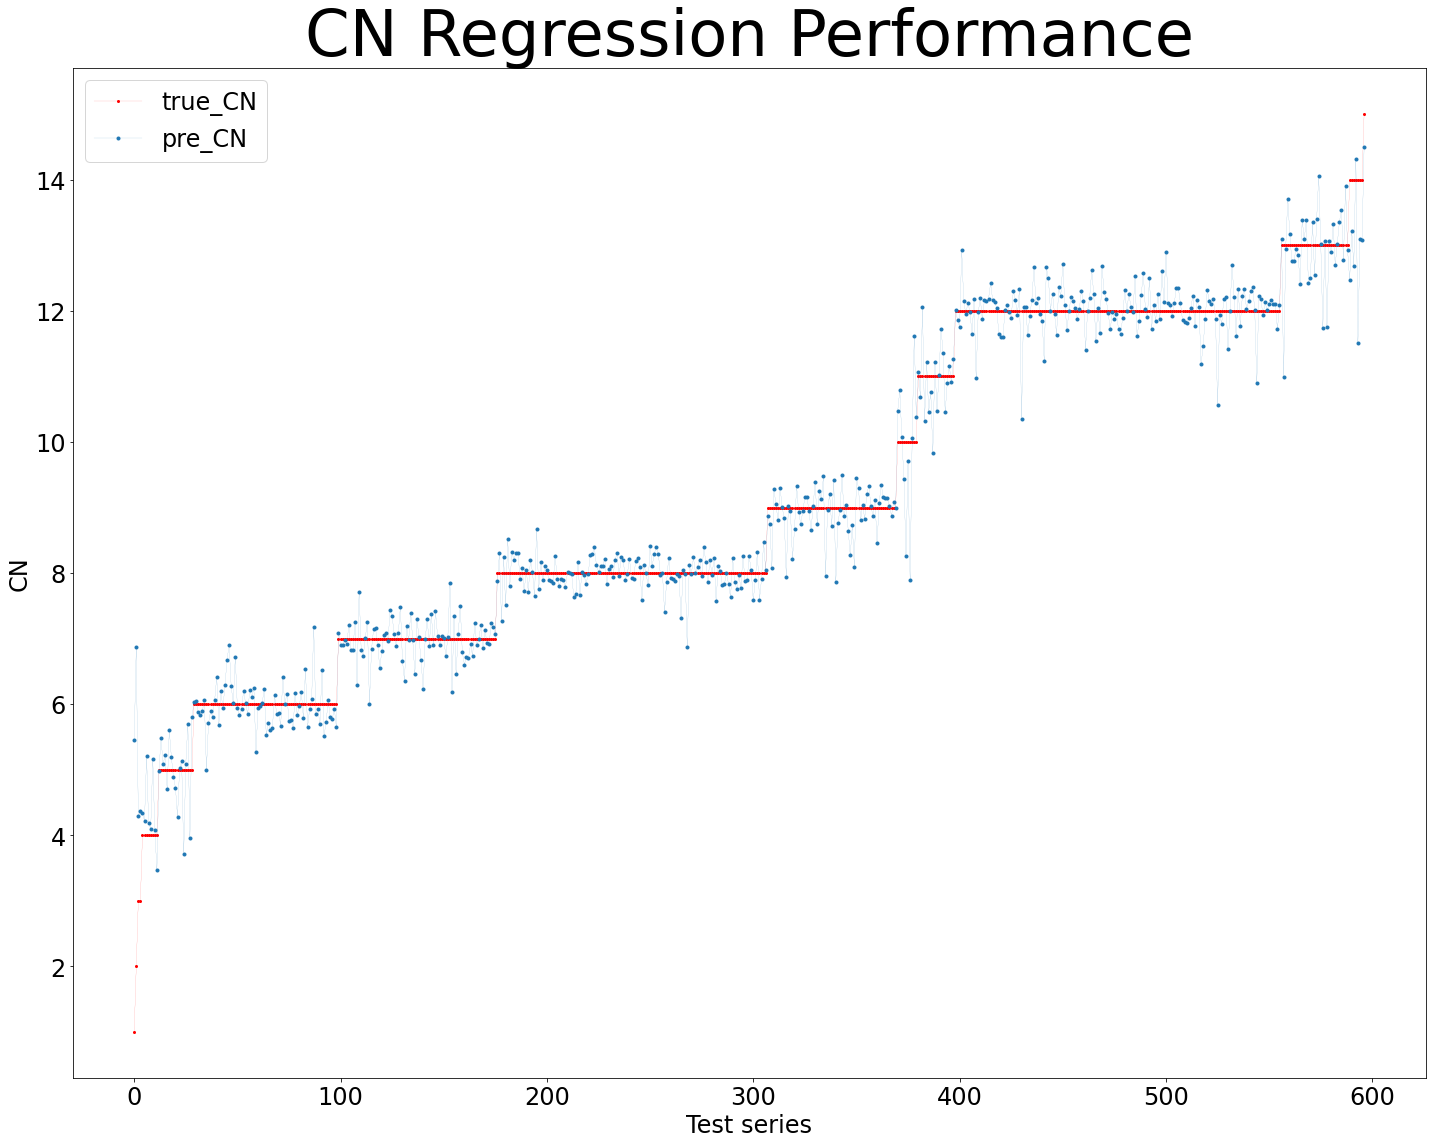

In [39]:
prediction_compare = file_pre + f"_prediction_compare_{label_index}"
x = range(pre.shape[0])
plt.figure(figsize = (20, 16))
plt.plot(x,label_test.flatten()[label_test.flatten().argsort()],'o-',color='r',linewidth = 0.1,markersize=2,label=f"true_{label_index}")
plt.plot(x,pre.flatten()[label_test.flatten().argsort()],'o-',linewidth = 0.1,markersize=3,label=f"pre_{label_index}")
plt.xlabel('Test series',fontsize=24)
plt.ylabel(f'{label_index}',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper left', fontsize=24)
plt.title(f"{label_index} Regression Performance", fontsize=64)
save_fig(prediction_compare, path_ana_work)

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_2


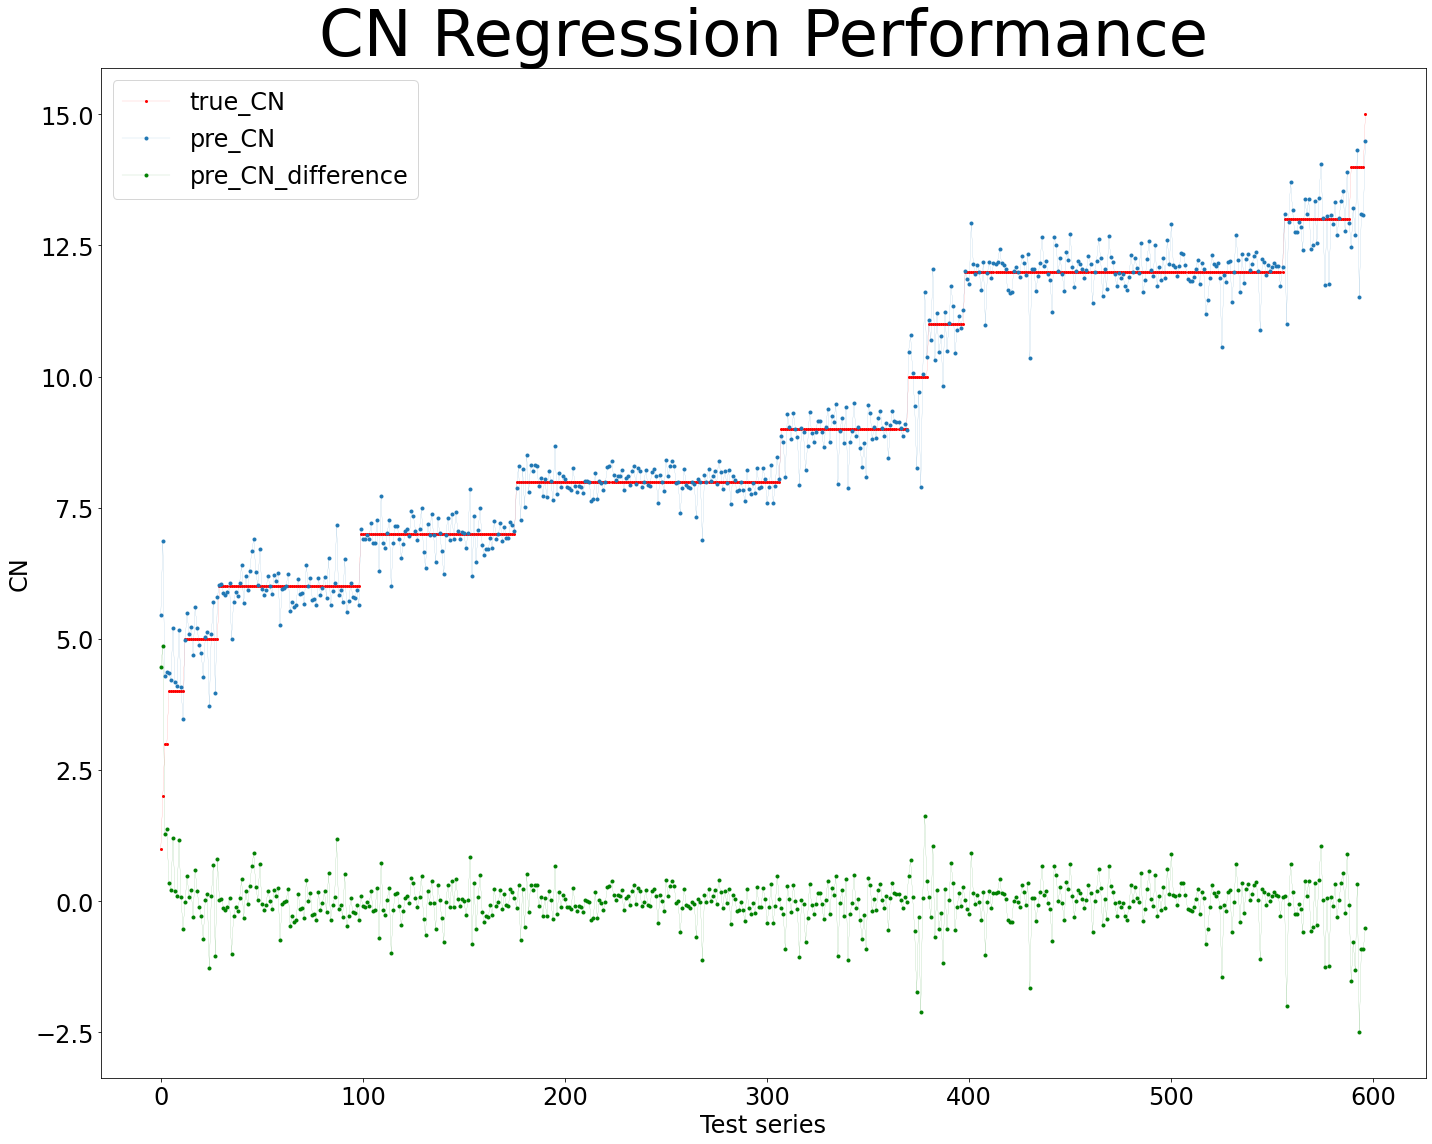

In [40]:
prediction_compare = file_pre + f"_prediction_compare_{label_index}_2"
x = range(pre.shape[0])
plt.figure(figsize = (20, 16))
plt.plot(x,label_test.flatten()[label_test.flatten().argsort()],'o-',color='r',linewidth = 0.1,markersize=2,label=f"true_{label_index}")
plt.plot(x,pre.flatten()[label_test.flatten().argsort()],'o-',linewidth = 0.1,markersize=3,label=f"pre_{label_index}")
plt.plot(x,diff.flatten()[label_test.flatten().argsort()],'o-',color='green',linewidth = 0.1,markersize=3,label=f"pre_{label_index}_difference")
plt.xlabel('Test series',fontsize=24)
plt.ylabel(f'{label_index}',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title(f"{label_index} Regression Performance", fontsize=64)
save_fig(prediction_compare, path_ana_work)

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_3


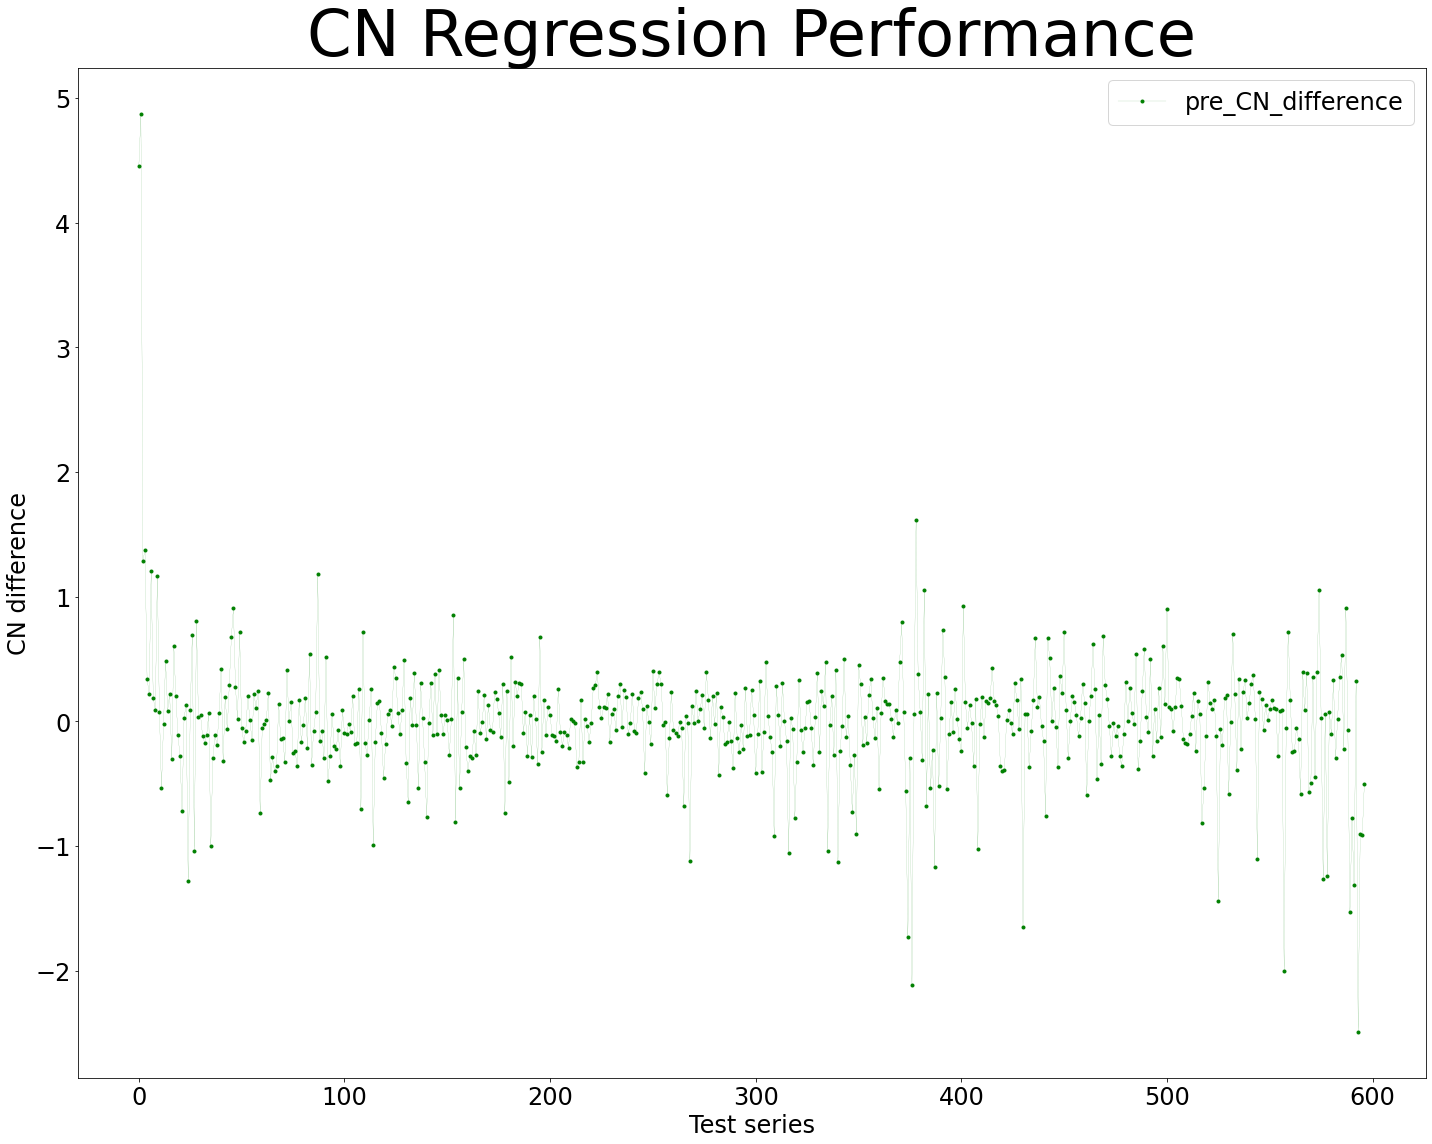

In [41]:
prediction_compare = file_pre + f"_prediction_compare_{label_index}_3"
x = range(pre.shape[0])
plt.figure(figsize = (20, 16))
plt.plot(x,diff.flatten()[label_test.flatten().argsort()],'o-',color='green',linewidth = 0.1,markersize=3,label=f"pre_{label_index}_difference")
plt.xlabel('Test series',fontsize=24)
plt.ylabel(f'{label_index} difference',fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
plt.title(f"{label_index} Regression Performance", fontsize=64)
save_fig(prediction_compare, path_ana_work)

#### 分段直接比较

In [42]:
def plot_PredictionCompare(x_low, x_high, x_ticks=10):
    """
    """
#
    prediction_compare = file_pre + f"_prediction_compare_{label_index}_{x_low}_{x_high}"
    x = range(pre.shape[0])
    plt.figure(figsize=(8, 8))
    plt.scatter(x,label_test, marker='o', s=50, label = f'{label_index}')  # s为标记大小
    plt.scatter(x,pre, marker='^', s=50, label = f'{label_index}_pre')
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}')
    plt.xlim(x_low,x_high)
    ylim_min0 = min(np.min(label_test[x_low:x_high]),np.min(pre[x_low:x_high]))
    ylim_max0 = max(np.max(label_test[x_low:x_high]),np.max(pre[x_low:x_high]))
    ylim_len = (ylim_max0 - ylim_min0)*1.1
    ylim_min = (ylim_min0 + ylim_max0)/2 - ylim_len/2
    ylim_max = (ylim_min0 + ylim_max0)/2 + ylim_len/2
    plt.ylim(ylim_min, ylim_max)
    plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(np.max(label_test)-1, np.max(label_test)+1, 2))
#plt.yticks(np.arange(np.around(np.min(label_test),1)-0.1, np.around(np.max(label_test),1)+0.1, 0.2))
#    plt.legend(loc='upper right', fontsize=12)
    plt.legend(fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(prediction_compare, path_cn_work)

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_0_50
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_50_100
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_100_150
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_150_200
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_200_250
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_250_300
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_300_350
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_350_400
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare_CN_400_450
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021

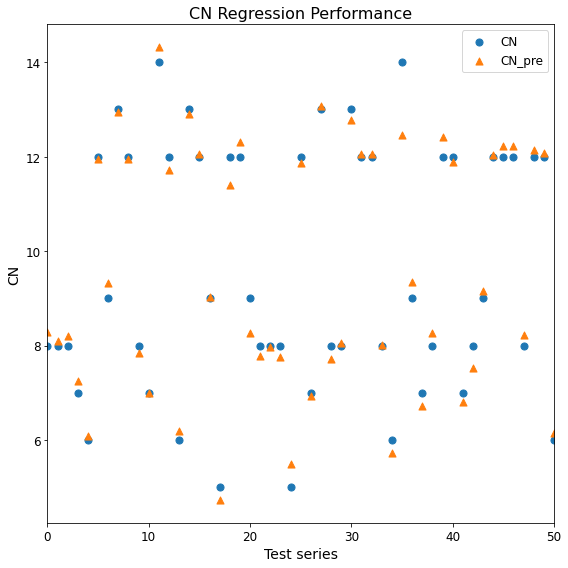

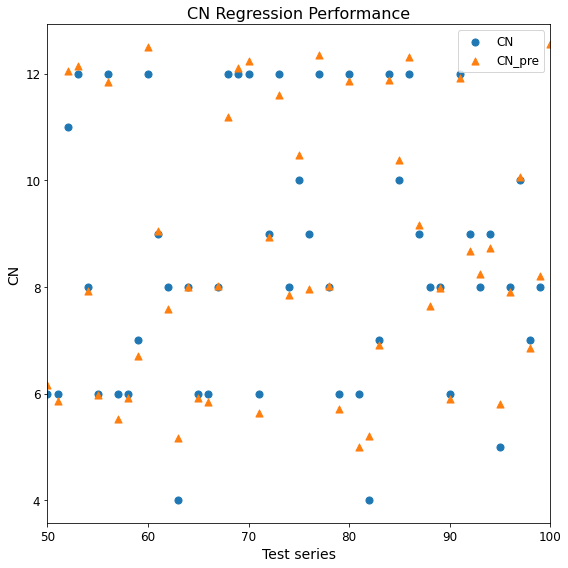

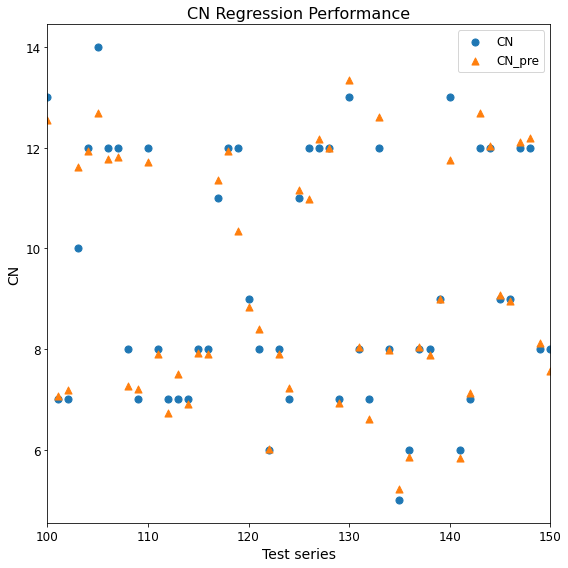

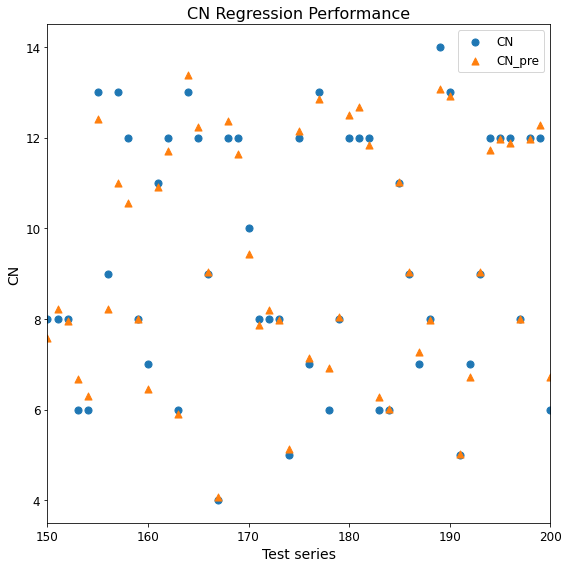

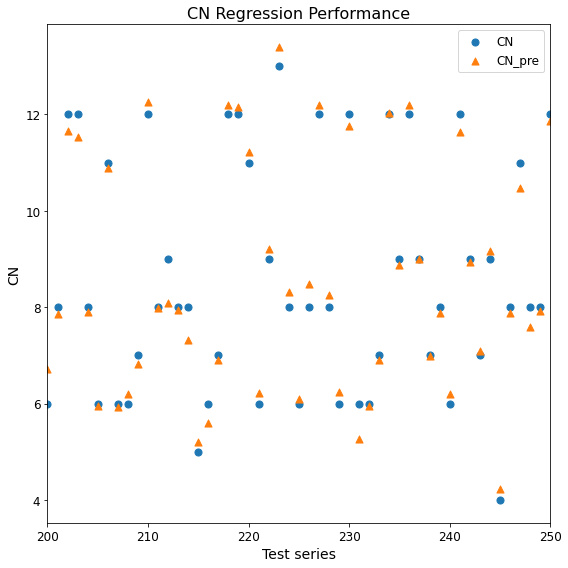

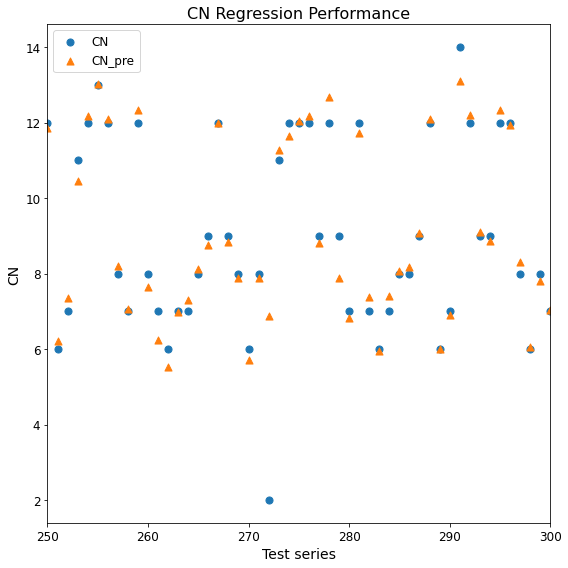

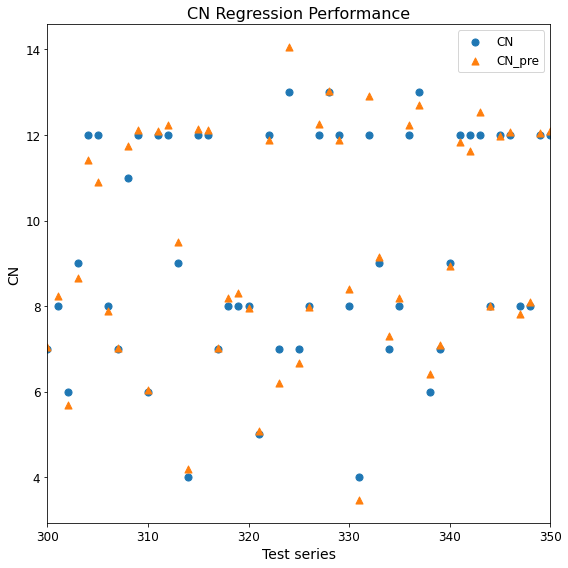

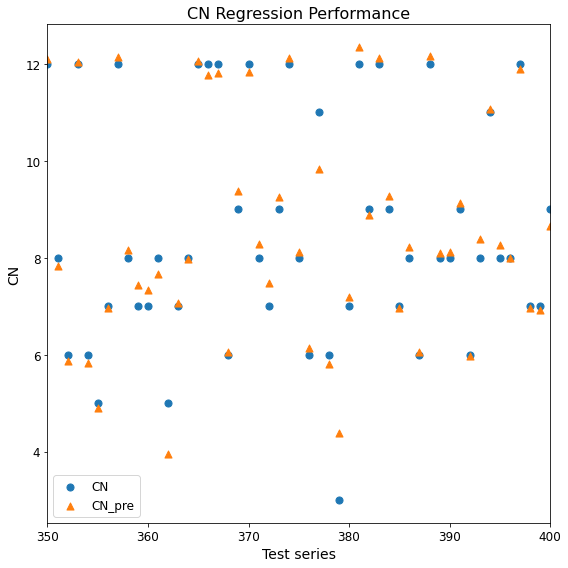

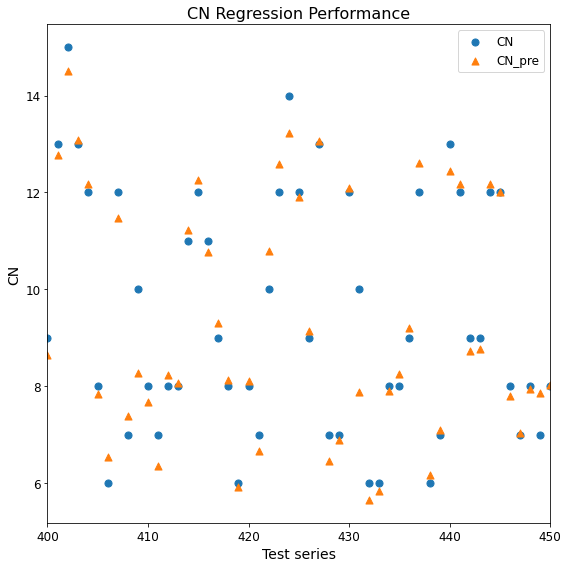

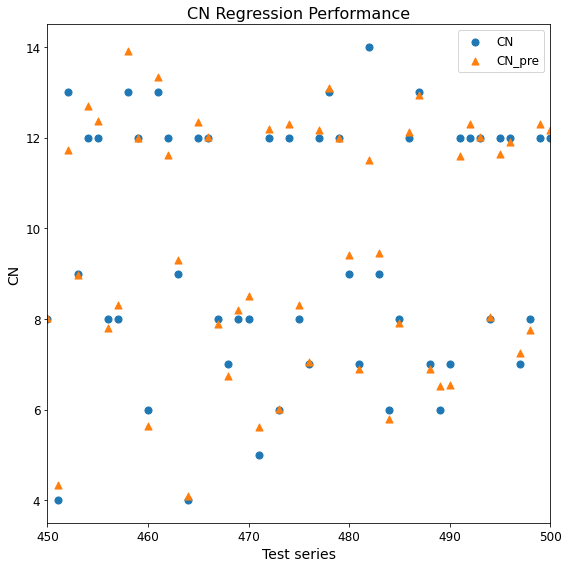

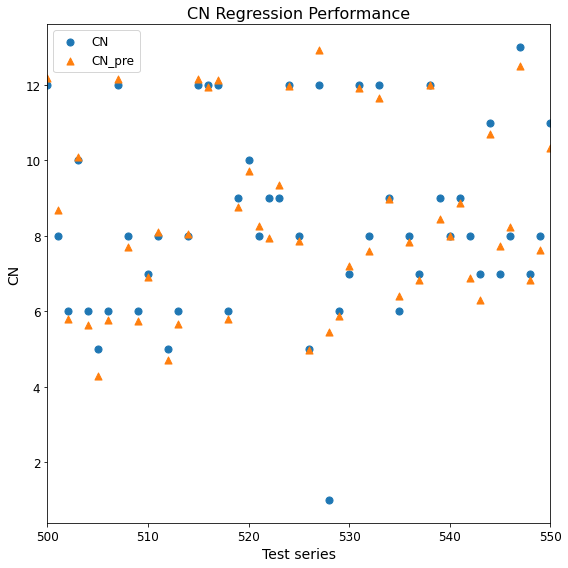

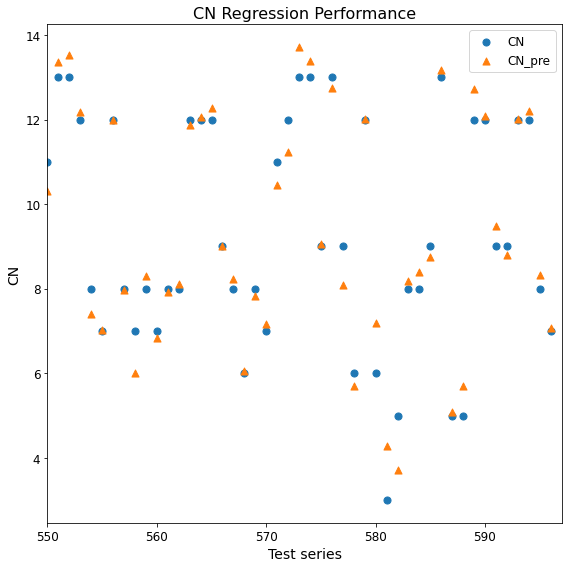

In [43]:
interval = 50
for i in range(0,pre.size, interval):
    plot_PredictionCompare(i, min(i+interval, pre.size))

###### 不同颜色（线条）

In [44]:
def plot_PredictionCompare2(x_low, x_high, x_ticks=10):
    """
    """
#
    prediction_compare = file_pre + f"_prediction_compare2_{label_index}_{x_low}_{x_high}"
    x = range(pre.shape[0])
    plt.figure(figsize=(10, 8))
    plt.plot(x,label_test, 'o-', markersize= 8, linewidth = 0.7, label = f'{label_index}')
    plt.plot(x,pre, '^-', color='red', markersize=8, linewidth = 0.7, label = f'{label_index}_pre')
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}')
    plt.xlim(x_low,x_high)
    ylim_min0 = min(np.min(label_test[x_low:x_high]),np.min(pre[x_low:x_high]))
    ylim_max0 = max(np.max(label_test[x_low:x_high]),np.max(pre[x_low:x_high]))
    ylim_len = (ylim_max0 - ylim_min0)*1.1
    ylim_min = (ylim_min0 + ylim_max0)/2 - ylim_len/2
    ylim_max = (ylim_min0 + ylim_max0)/2 + ylim_len/2
    plt.ylim(ylim_min, ylim_max)
    plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#    plt.yticks(np.arange(np.around(np.min(label_test),1)-0.1, np.around(np.max(label_test),1)+0.1, 0.2))
#    plt.legend(loc='upper right', fontsize=12)
    plt.legend(fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(prediction_compare, path_cn_work)

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_0_50
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_50_100
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_100_150
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_150_200
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_200_250
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_250_300
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_300_350
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_350_400
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare2_CN_400_450
Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1

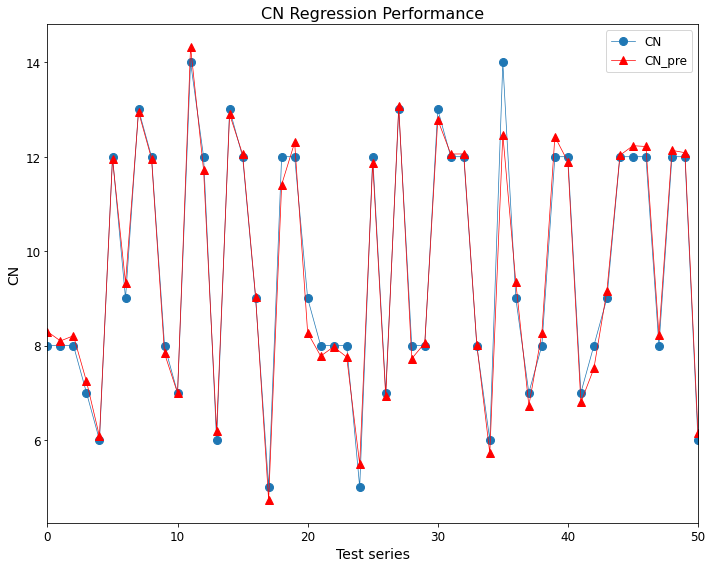

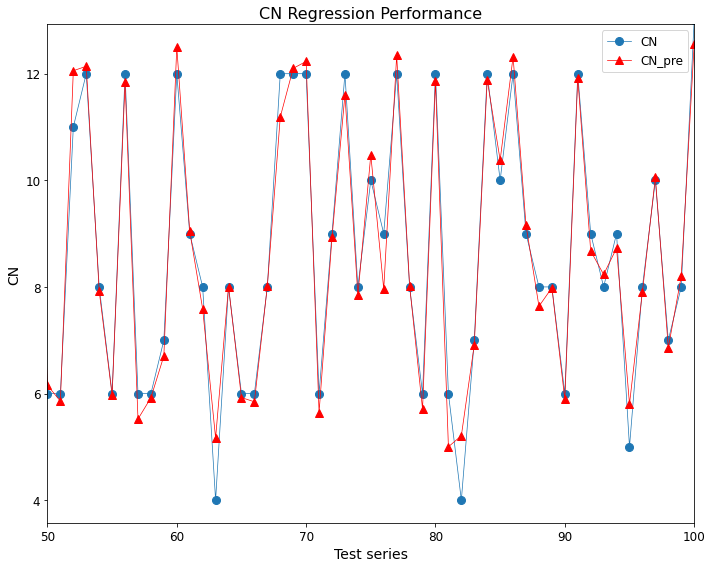

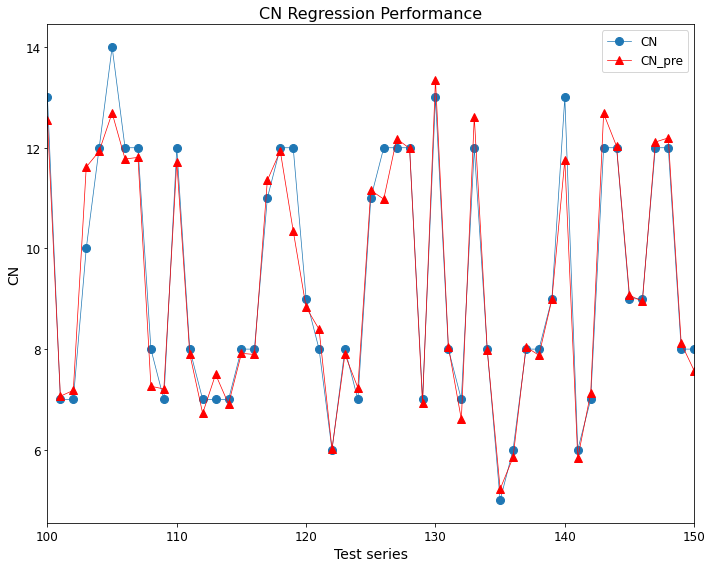

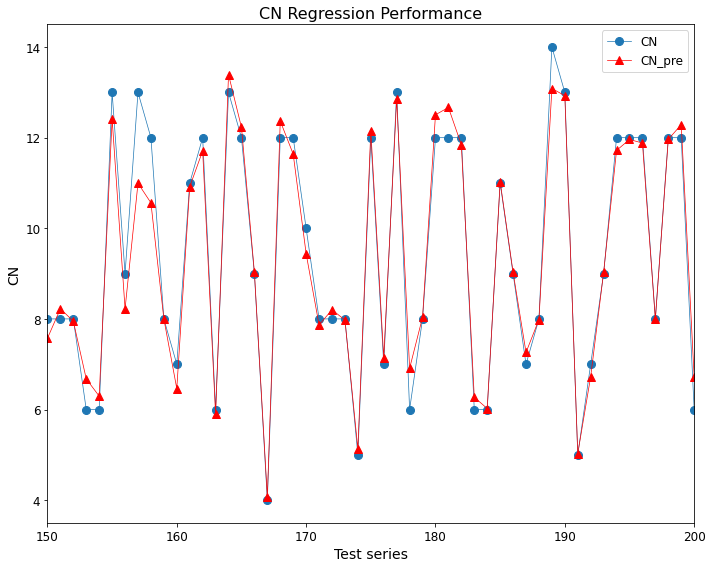

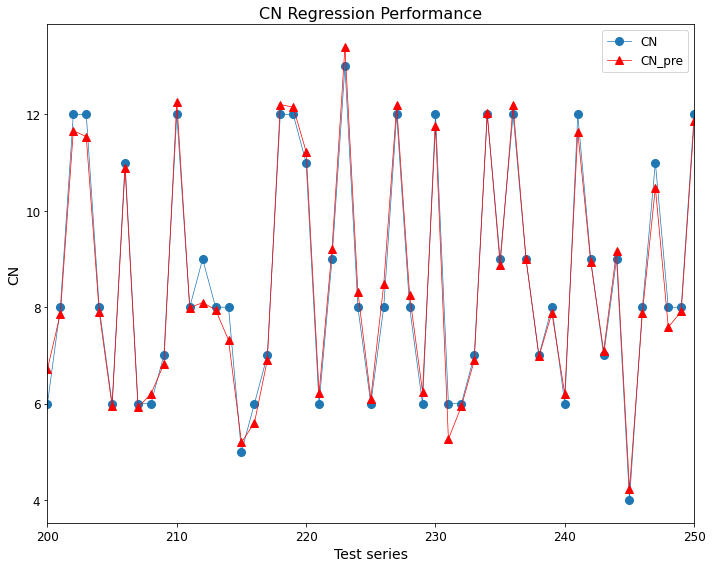

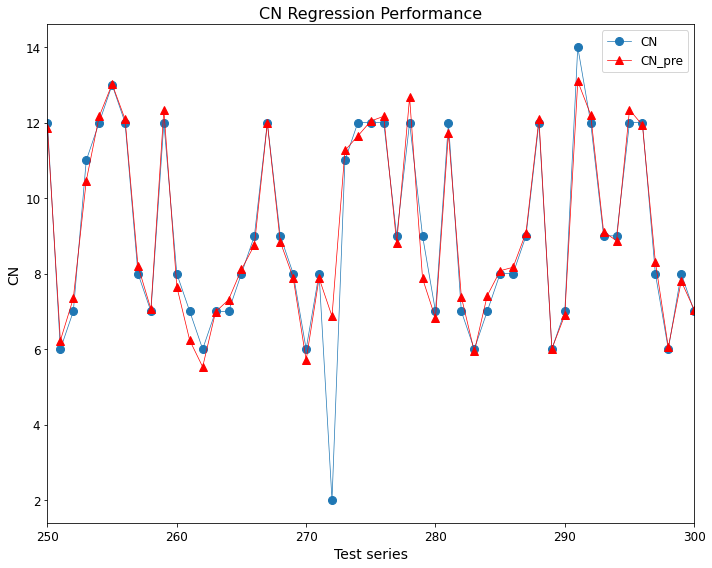

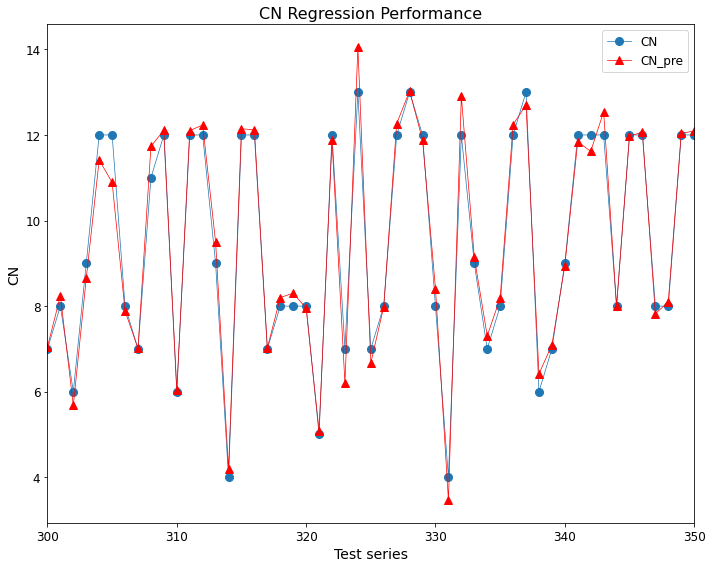

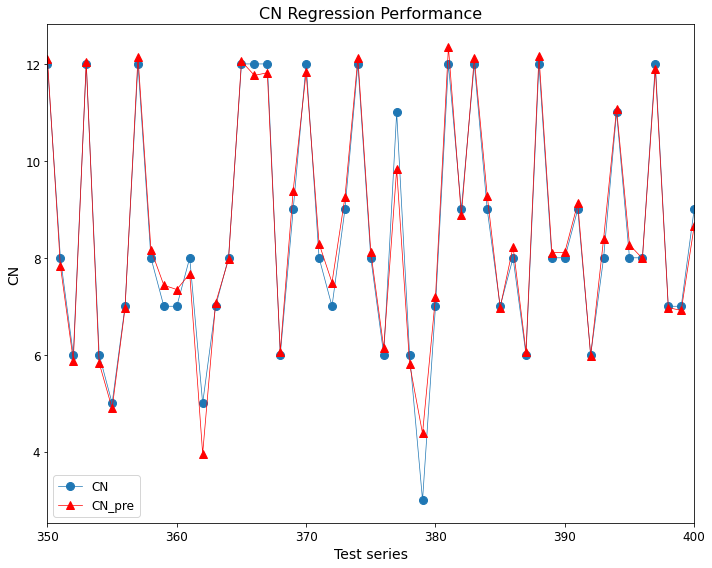

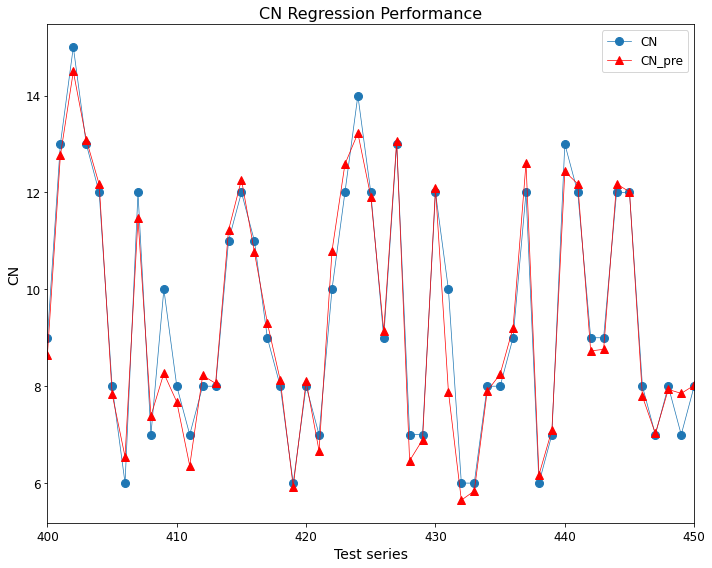

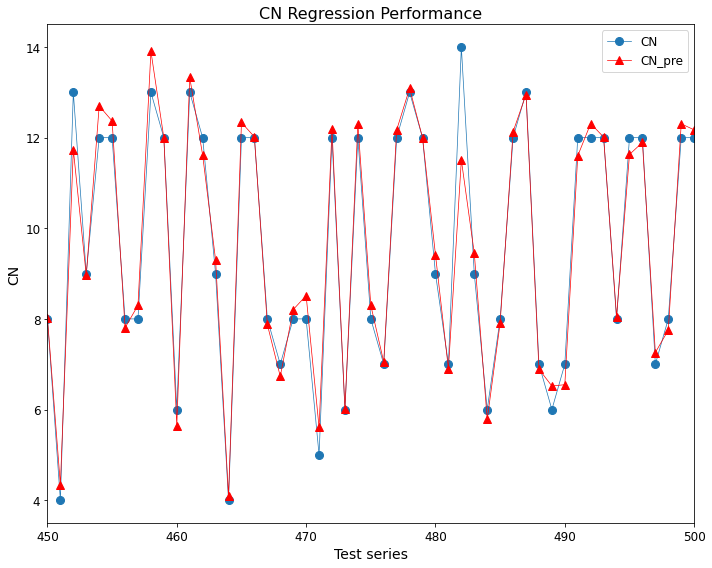

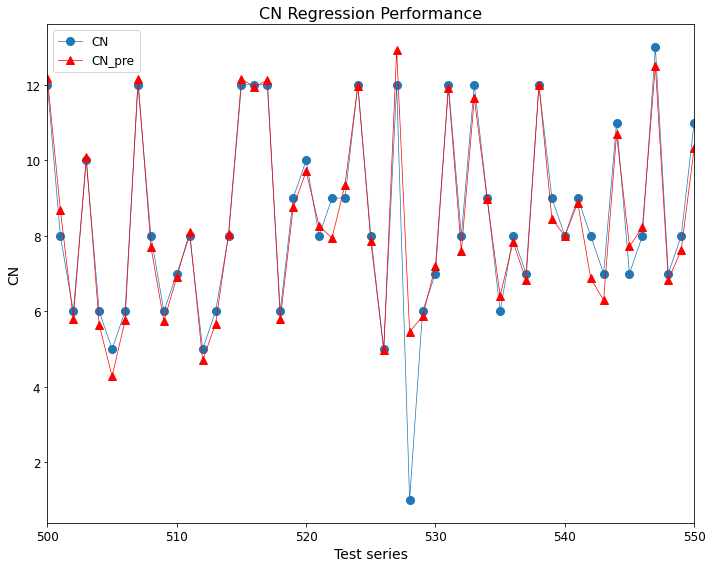

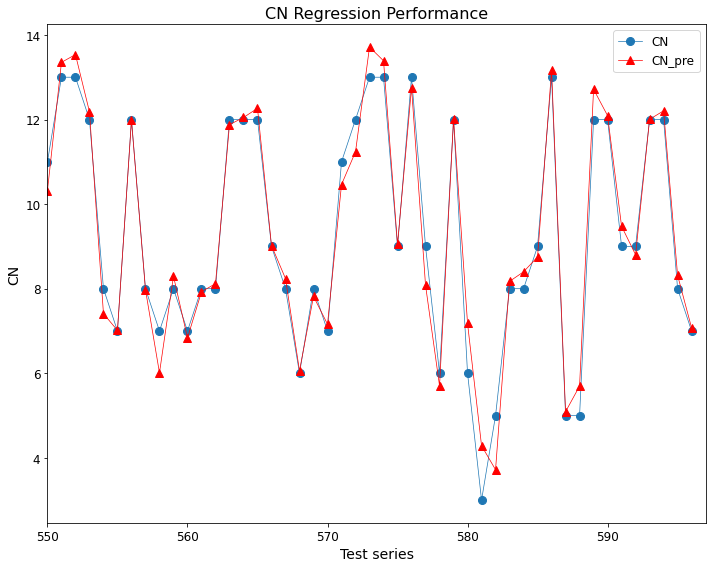

In [45]:
interval = 50
for i in range(0,pre.size, interval):
    plot_PredictionCompare2(i, min(i+interval, pre.size))

#### 想画哪个就画哪个

In [46]:
# x_low and x_high are the border of x-axis for plotting
x_low = 0
x_high = 100
# x_ticks is the step show for x-axis plottong
x_ticks = 10

In [47]:
def plot_PredictionCompare3(x_low, x_high, x_ticks=10):
    """
    """
#
    prediction_compare = file_pre + f"_prediction_compare3_{label_index}_{x_low}_{x_high}"
    x = range(pre.shape[0])
    plt.figure(figsize = (10, 8))
    plt.plot(x,label_test.flatten()[label_test.flatten().argsort()],'o-',color='r',linewidth = 0.1,markersize=2,label=f"true_{label_index}")
    plt.plot(x,pre.flatten()[label_test.flatten().argsort()],'o-',linewidth = 0.1,markersize=3,label=f"pre_{label_index}")
    plt.xlabel('Test series')
    plt.ylabel(f'{label_index}')
    plt.xlim(x_low,x_high)
    plt.xticks(np.arange(x_low,x_high+1,x_ticks), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(0, np.max(label_test)+1, 2))
    plt.legend(loc='upper left', fontsize=12)
    plt.title(f"{label_index} Regression Performance", fontsize=16)
    save_fig(prediction_compare, path_ana_work)

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_prediction_compare3_CN_0_100


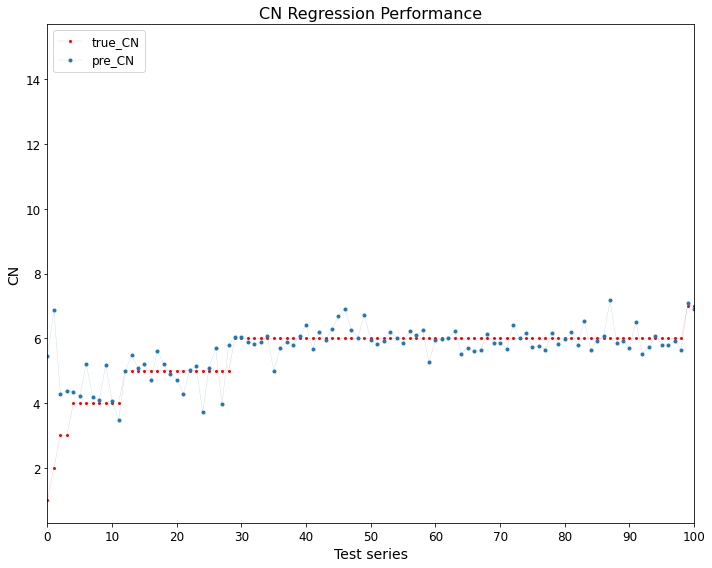

In [48]:
plot_PredictionCompare3(x_low, x_high, x_ticks)

#### parity chart for CN

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_parity


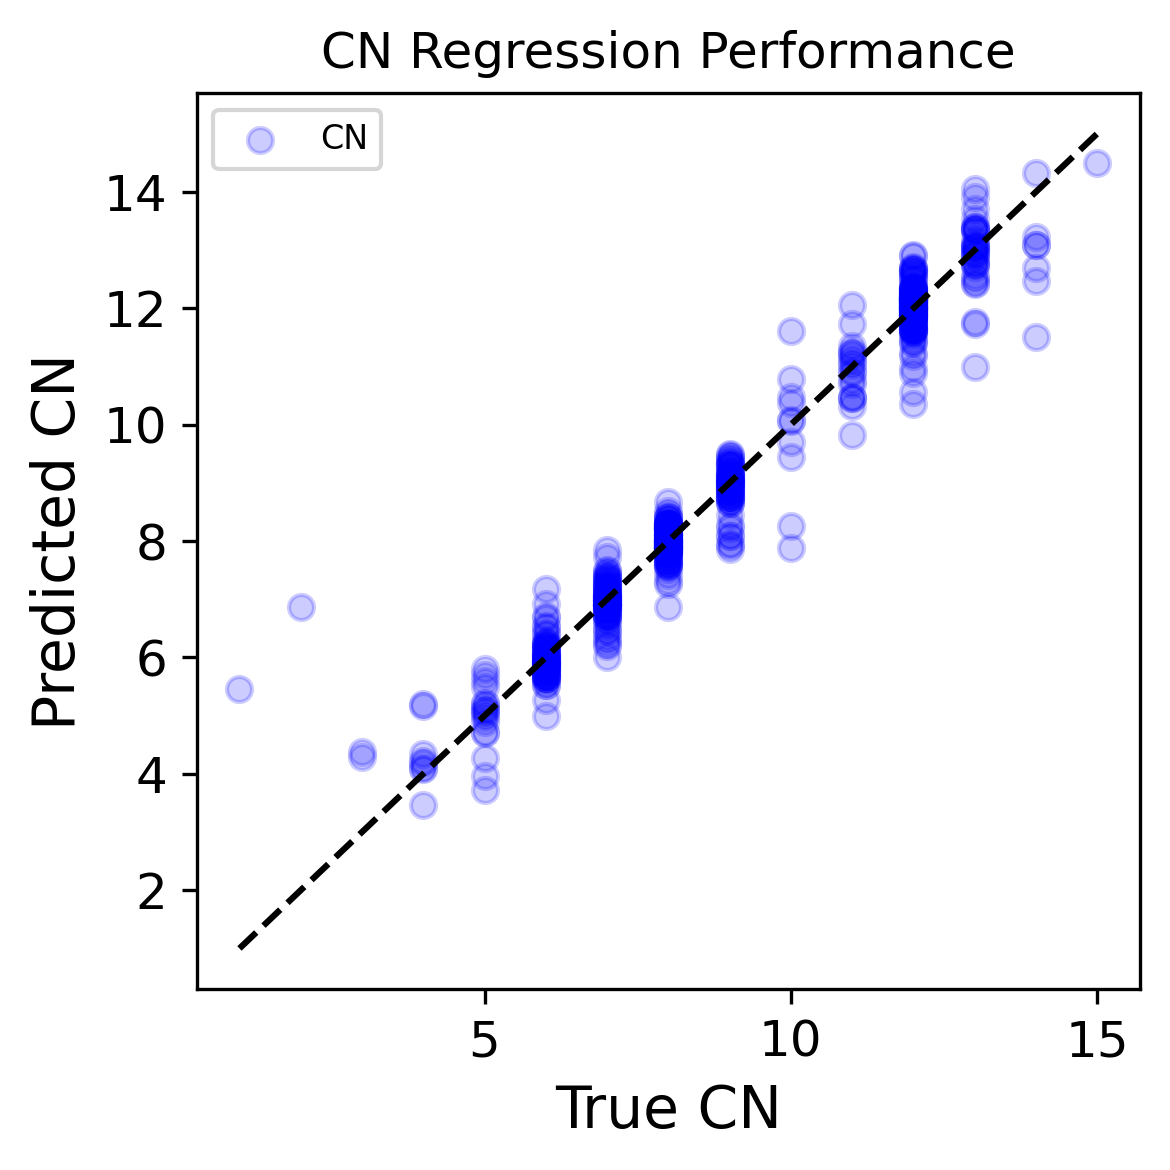

In [49]:
fig_parity = file_pre + '_parity'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            pre.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'blue', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                pre.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'blue', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(a, b),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance",fontsize=12)
plt.xlabel(f"True {label_index}")
plt.ylabel(f"Predicted {label_index}")
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(fig_parity, path_ana_work)

#### Distribution for label predict difference

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_parity_difference


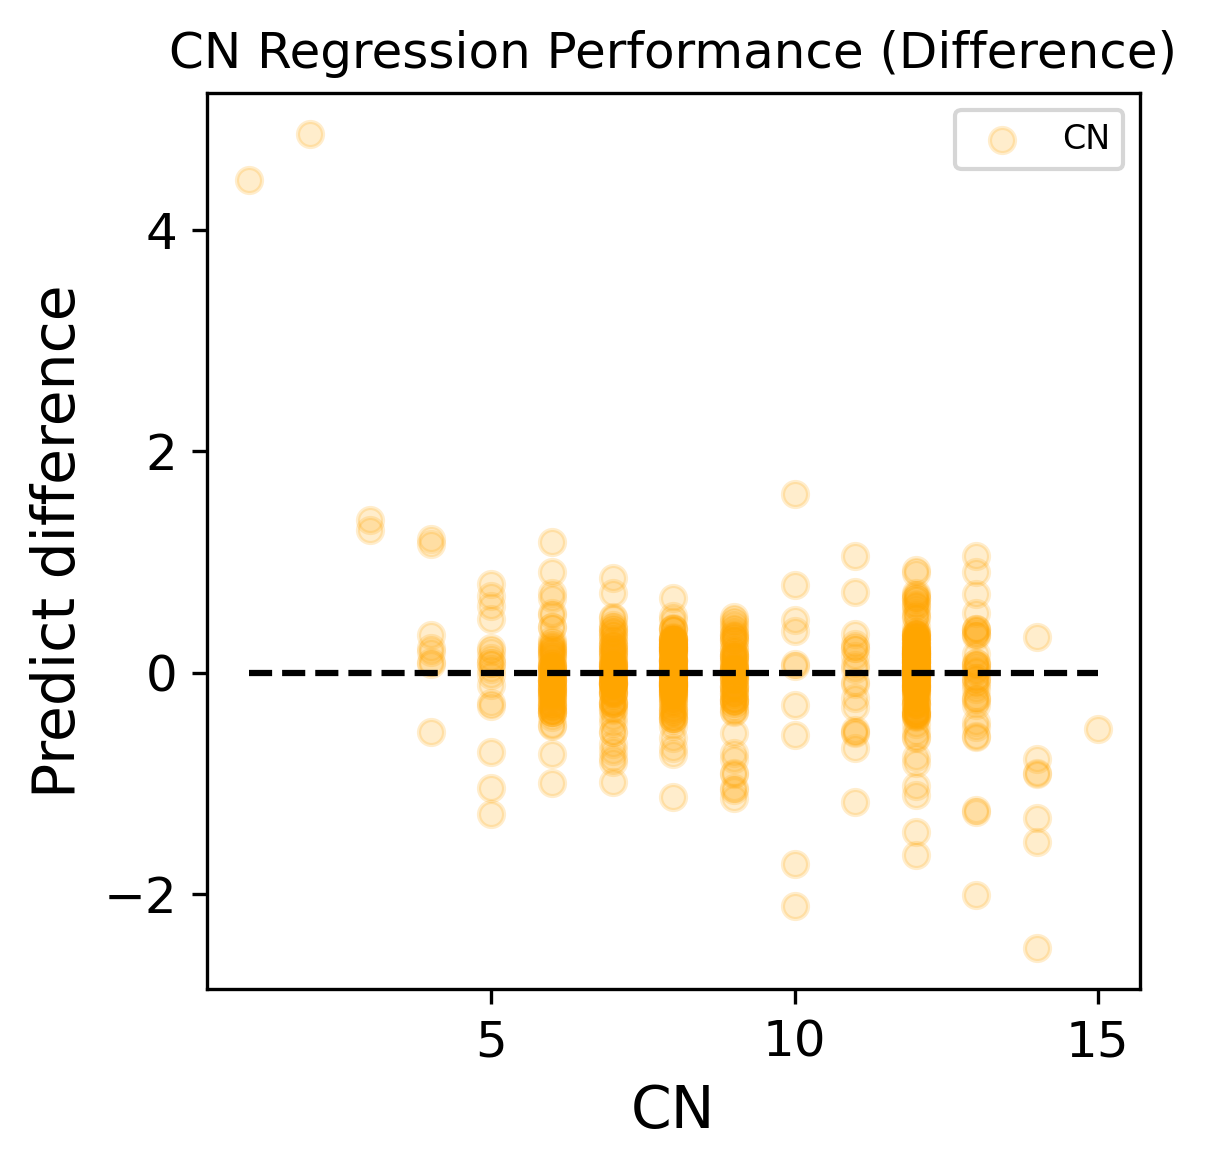

In [50]:
fig_diff = file_pre + '_parity' + '_difference'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            diff.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'orange', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                diff.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'orange', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(0, 0),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance (Difference)",fontsize=12)
plt.xlabel(f"{label_index}")
plt.ylabel(f"Predict difference")
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(fig_diff, path_ana_work)

#### Distribution for CN error

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_parity_error


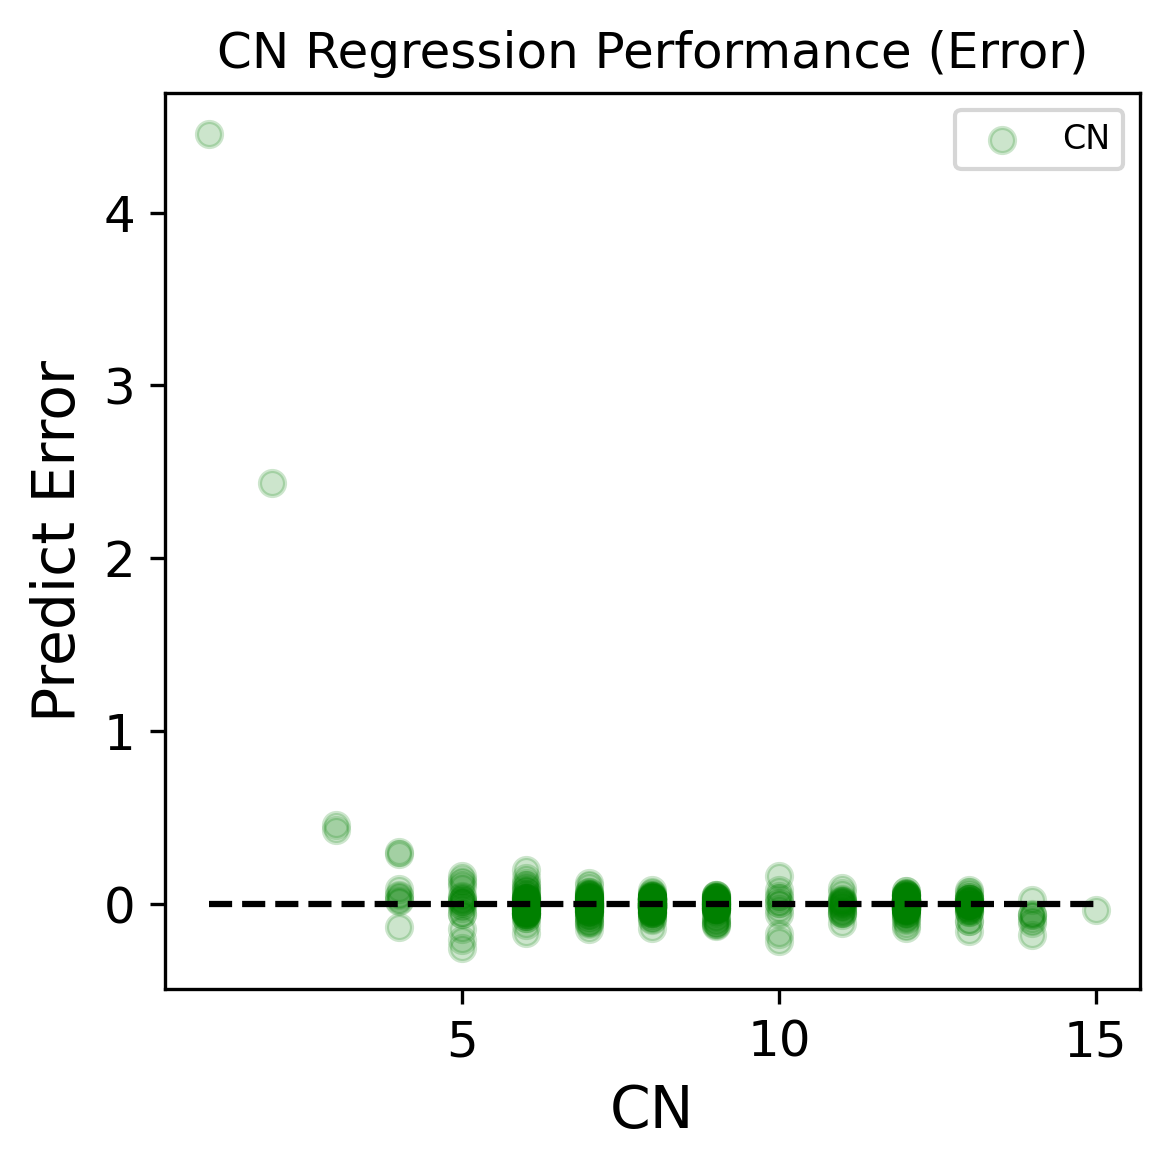

In [51]:
fig_err = file_pre + '_parity' + '_error'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            err.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'green', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                err.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'green', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(0, 0),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance (Error)",fontsize=12)
plt.xlabel(f"{label_index}")
plt.ylabel(f"Predict Error")
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(fig_err, path_ana_work)

上图放大的情况，即将y轴取定范围。

Saving figure Au_chi_test_au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11_parity_error_zoom


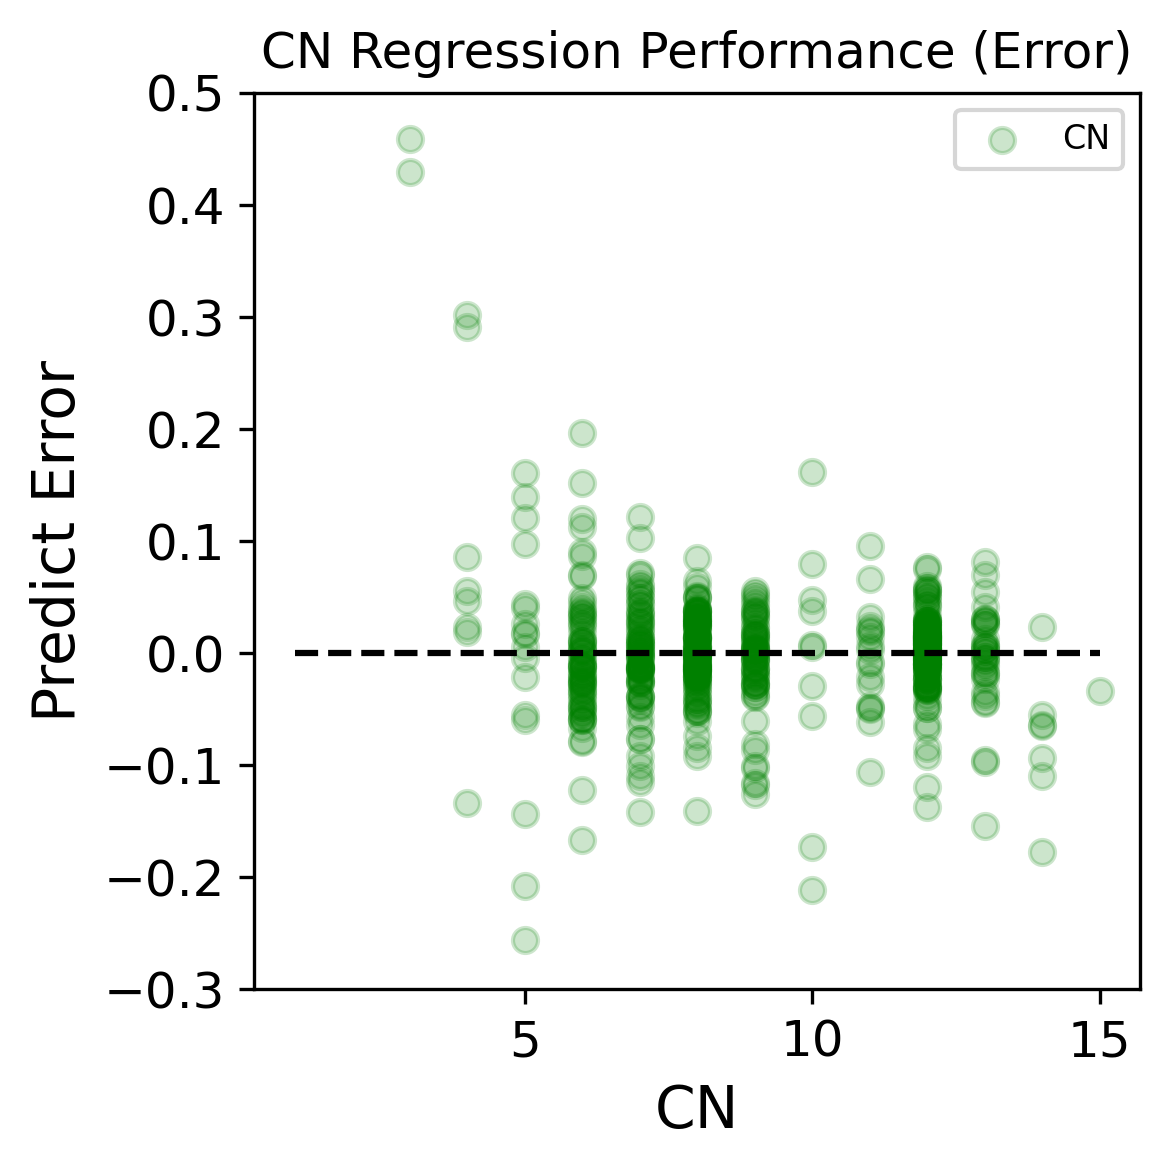

In [52]:
fig_err = file_pre + '_parity' + '_error_zoom'
number = pre.shape[0]
#
plt.figure(figsize=(4,4),dpi=300)
plt.scatter(label_test.flatten()[0],
            err.flatten()[0],
            zorder = -1,
            marker = 'o',
            color = 'green', 
            alpha = 0.2,
            label = label_index)
#
for i in range(number)[1:]:
    plt.scatter(label_test.flatten()[i],
                err.flatten()[i],
                zorder = np.random.uniform(0,1),
                marker = 'o',
                color = 'green', 
#                alpha = 100/number,
                alpha = 0.2)
#
a = np.min(label_test)
b = np.max(label_test)
plt.plot((a, b),(0, 0),color='black',ls='--')
plt.legend(fontsize=8)
plt.title(f"{label_index} Regression Performance (Error)",fontsize=12)
plt.xlabel(f"{label_index}")
plt.ylabel(f"Predict Error")
plt.ylim(-0.3,0.5)
#plt.xticks(np.arange(a,b,0.1), rotation=0)#rotation控制倾斜角度
#plt.yticks(np.arange(a,b,0.1))
save_fig(fig_err, path_ana_work)

注：若是配位键长预测，只需在上述代码中修改模型文件、label_index和label_test即可。注意图形绘制时的步长要做相应变化。

## 针对各个label（区间）进行分析

### 各个CN（区间）分析

#### 基本设置

In [53]:
# 绘图/统计CN的最小间隔，digit为小数点后位数，主要为绘图设置
step = 0.1
digit = 1
prf_step = f"_step={step}"

#### 单个label细致统计

In [54]:
label_min = np.min(label_test)
label_max = np.max(label_test)
pre_max = np.max(pre)
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
trivial = min(0.00001, step/100)
#
dim_max = int((max(pre_max,label_max) + trivial) / step)
# CN[i][j] 表示原值为i的样本，预测落到[j*step,(j+1)*step)中的个数
# CN_min[i]和CN_max[i]表示原值为i的样本，其预测落到区间的最小和最大j值
# CN_index[i][j]表示原值为i、预测值落到区间[j*step,(j+1)*step)的样本在label_test中的标号，它是一个列表；
# CN_list[i][j]表示原值为i、预测值落到区间[j*step,(j+1)*step)的样本在label_test中的标号所对应的预测值，它也是一个列表。
# CN_diff[i]表示原值为i的样本，对应于CN_list[i]列表的预测值的偏差。
# CN_diff_abs、CN_err意思同上。
CN = np.zeros((round(label_max)+1,dim_max+1),dtype=int)
CN_max = []
CN_min = []
CN_index = []
CN_list = []
CN_diff = []
CN_diff_abs = []
CN_err = []
CN_err_abs = []
CN_all_min = dim_max
CN_all_max = 0
for i in range(round(label_max)+1):
    CN_max.append(0)
    CN_min.append(dim_max)
    CN_index.append([])
    CN_list.append([])
    for j in range(dim_max+1):
        CN_index[i].append([])
        CN_list[i].append([])
    CN_diff.append([])
    CN_diff_abs.append([])
    CN_err.append([])
    CN_err_abs.append([])
#
for i in range(pre.size):
    m = round(label_test[i][0])
    n = int((pre[i][0]+trivial)/step)
    CN[m][n] += 1
    CN_max[m] = max(CN_max[m],n)
    CN_min[m] = min(CN_min[m],n)
    CN_all_max = max(CN_all_max, CN_max[m])
    CN_all_min = min(CN_all_min, CN_min[m])
#
    CN_index[m][n].append(i)
    CN_list[m][n].append(pre[i][0])
    CN_diff[m].append(diff[i][0])
    CN_diff_abs[m].append(diff_abs[i][0])
    CN_err[m].append(err[i][0])
    CN_err_abs[m].append(err_abs[i][0])
#
CN_sum = np.sum(CN, axis=0)
CN_all_sum = np.sum(CN_sum)

In [55]:
CN_list_avg = np.zeros(round(label_max)+1)
CN_list_avg = [0] * (round(label_max)+1)
CN_list_var = [0] * (round(label_max)+1)
CN_list_std = [0] * (round(label_max)+1)
CN_diff_avg = [0] * (round(label_max)+1)
CN_diff_var = [0] * (round(label_max)+1)
CN_diff_std = [0] * (round(label_max)+1)
CN_diff_abs_avg = [0] * (round(label_max)+1)
CN_diff_abs_var = [0] * (round(label_max)+1)
CN_diff_abs_std = [0] * (round(label_max)+1)
CN_err_avg = [0] * (round(label_max)+1)
CN_err_var = [0] * (round(label_max)+1)
CN_err_std = [0] * (round(label_max)+1)
CN_err_abs_avg = [0] * (round(label_max)+1)
CN_err_abs_var = [0] * (round(label_max)+1)
CN_err_abs_std = [0] * (round(label_max)+1)
for i in range(round(label_min), round(label_max)+1):
    a = []
    for j in range(dim_max+1):
        a += CN_list[i][j]
    CN_list_avg[i] = np.mean(np.array(a))
    CN_list_var[i] = np.var(np.array(a))
    CN_list_std[i] = np.std(np.array(a))
    CN_diff_avg[i] = np.mean(np.array(CN_diff[i]))
    CN_diff_var[i] = np.var(np.array(CN_diff[i]))
    CN_diff_std[i] = np.std(np.array(CN_diff[i]))
    CN_diff_abs_avg[i] = np.mean(np.array(CN_diff_abs[i]))
    CN_diff_abs_var[i] = np.var(np.array(CN_diff_abs[i]))
    CN_diff_abs_std[i] = np.std(np.array(CN_diff_abs[i]))
    CN_err_avg[i] = np.mean(np.array(CN_err[i]))
    CN_err_var[i] = np.var(np.array(CN_err[i]))
    CN_err_std[i] = np.std(np.array(CN_err[i]))
    CN_err_abs_avg[i] = np.mean(np.array(CN_err_abs[i]))
    CN_err_abs_var[i] = np.var(np.array(CN_err_abs[i]))
    CN_err_abs_std[i] = np.std(np.array(CN_err_abs[i]))

#### 数列调整
包含左右零

In [56]:
# list_CN 、count_CN 为数列，其第i个元素为调整过的配位数列表
list_CN = []
count_CN = []
for i in range(round(label_min)):
    list_CN.append([])
    count_CN.append([])
for i in range(round(label_min), round(label_max)+1):
    b, c = list_modify(CN_min[i], CN_max[i], CN[i])
    list_CN.append(b)
    count_CN.append(c)

#### 绘图

In [57]:
for i in range(round(label_min), round(label_max)+1):
    file = label_index + f"_{i}" + prf_step
    plot_pre_cn(i, list(CN[i]), CN_min[i], CN_max[i], step, digit, path_cn_work, file)

Saving figure CN_1_step=0.1
Saving figure CN_2_step=0.1
Saving figure CN_3_step=0.1
Saving figure CN_4_step=0.1
Saving figure CN_5_step=0.1
Saving figure CN_6_step=0.1
Saving figure CN_7_step=0.1
Saving figure CN_8_step=0.1
Saving figure CN_9_step=0.1
Saving figure CN_10_step=0.1
Saving figure CN_11_step=0.1
Saving figure CN_12_step=0.1
Saving figure CN_13_step=0.1
Saving figure CN_14_step=0.1
Saving figure CN_15_step=0.1


### 各个CN的error（区间）分析

#### 基本设置

In [58]:
# 绘图/统计CN的最小间隔，digit为小数点后位数，主要为绘图设置
step_err = 0.01
digit_err = 2
prf_step_err = f"_step={step_err}"

#### 单个label的预测误差统计

In [59]:
label_min = np.min(label_test)
label_max = np.max(label_test)
err_all_min = np.min(err)
err_all_max = np.max(err)
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
trivial = min(0.00001, step_err/100)
#
dim_err_max = math.floor((err_all_max + trivial) / step_err)
dim_err_min = math.floor((err_all_min + trivial) / step_err)
dim_err = dim_err_max - dim_err_min + 1
#  ERR[i][j]表示原值为i的样本，预测error落到[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)中的个数
# ERR_min[i]和ERR_max[i]表示原值为i的样本，其预测error的最小和最大值落到区间的j值
# ERR_index[i][j]表示原值为i、预测error落到区间[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)的样本在label_test中的标号，它是一个列表；
# ERR_list[i][j]表示原值为i、预测error落到区间[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)的样本在label_test中的标号所对应的预测error值，它也是一个列表。
# ERR_all_min和ERR_all_max是ERR_min[]和ERR_max[]中的最小和最大值
# err_min[i]和err_max[i]是原值为i的样本，误差最小和最大值。
ERR = np.zeros((round(label_max)+1,dim_err),dtype=int)
ERR_max = []
ERR_min = []
ERR_index = []
ERR_list = []
ERR_all_min = dim_err_max
ERR_all_max = dim_err_min
err_min = []
err_max = []
for i in range(round(label_max)+1):
    ERR_max.append(dim_err_min)
    ERR_min.append(dim_err_max)
    ERR_index.append([])
    ERR_list.append([])
    for j in range(dim_err):
        ERR_index[i].append([])
        ERR_list[i].append([])
    err_max.append(err_all_min)
    err_min.append(err_all_max)
#
for i in range(pre.size):
    m = round(label_test[i][0])
    n0 = math.floor((err[i][0]+trivial)/step_err)
    n = n0 - dim_err_min
    ERR[m][n] += 1
    ERR_max[m] = max(ERR_max[m],n)
    ERR_min[m] = min(ERR_min[m],n)
    ERR_all_max = max(ERR_all_max, ERR_max[m])
    ERR_all_min = min(ERR_all_min, ERR_min[m])
#
    ERR_index[m][n].append(i)
    ERR_list[m][n].append(err[i][0])
#
    err_max[m] = max(err_max[m], err[i][0])
    err_min[m] = min(err_min[m], err[i][0])
#
ERR_sum = np.sum(ERR, axis=0)
ERR_all_sum = np.sum(ERR_sum)

#### 数列调整
包含左右零

In [60]:
list_ERR = []
count_ERR = []
for i in range(round(label_min)):
    list_ERR.append([])
    count_ERR.append([])
for i in range(round(label_min), round(label_max)+1):
    b, c = list_modify(ERR_min[i], ERR_max[i], ERR[i])
    list_ERR.append(b)
    count_ERR.append(c)

#### 绘图（Error）

In [61]:
for i in range(round(label_min), round(label_max)+1):
    file = label_index + '_err' + f"_{i}" + prf_step_err
    plot_pre_cn_err(i, err_min[i], err_max[i], list(ERR[i]), ERR_min[i], ERR_max[i], dim_err_min, step_err, digit_err, path_cn_work, file)

Saving figure CN_err_1_step=0.01
Saving figure CN_err_2_step=0.01
Saving figure CN_err_3_step=0.01
Saving figure CN_err_4_step=0.01
Saving figure CN_err_5_step=0.01
Saving figure CN_err_6_step=0.01
Saving figure CN_err_7_step=0.01
Saving figure CN_err_8_step=0.01
Saving figure CN_err_9_step=0.01
Saving figure CN_err_10_step=0.01
Saving figure CN_err_11_step=0.01
Saving figure CN_err_12_step=0.01
Saving figure CN_err_13_step=0.01
Saving figure CN_err_14_step=0.01
Saving figure CN_err_15_step=0.01


### 各个CN的error绝对值分析

#### 基本设置

In [62]:
# 绘图/统计CN的最小间隔，digit为小数点后位数，主要为绘图设置
step_err = 0.01
digit_err = 2
prf_step_err = f"_step={step_err}"

#### 单个label的预测误差绝对值统计

In [63]:
label_min = np.min(label_test)
label_max = np.max(label_test)
err_abs_all_min = np.min(err_abs)
err_abs_all_max = np.max(err_abs)
#  trivial用于避免计算机对边界数据处理不当导致的统计误差。
trivial = min(0.00001, step_err/100)
#
dim_err_abs_max = math.floor((err_abs_all_max + trivial) / step_err)
dim_err_abs_min = math.floor((err_abs_all_min + trivial) / step_err)
dim_err_abs = dim_err_abs_max - dim_err_abs_min + 1
#  ERR[i][j]表示原值为i的样本，预测error落到[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)中的个数
# ERR_min[i]和ERR_max[i]表示原值为i的样本，其预测error的最小和最大值落到区间的j值
# ERR_index[i][j]表示原值为i、预测error落到区间[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)的样本在label_test中的标号，它是一个列表；
# ERR_list[i][j]表示原值为i、预测error落到区间[(j+dim_err_min)*step_err,(j+1+dim_err_min)*step_err)的样本在label_test中的标号所对应的预测error值，它也是一个列表。
# ERR_all_min和ERR_all_max是ERR_min[]和ERR_max[]中的最小和最大值
# err_min[i]和err_max[i]是原值为i的样本，误差最小和最大值。
ERR_abs = np.zeros((round(label_max)+1,dim_err_abs),dtype=int)
ERR_abs_max = []
ERR_abs_min = []
ERR_abs_index = []
ERR_abs_list = []
ERR_abs_all_min = dim_err_abs_max
ERR_abs_all_max = dim_err_abs_min
err_abs_min = []
err_abs_max = []
for i in range(round(label_max)+1):
    ERR_abs_max.append(dim_err_abs_min)
    ERR_abs_min.append(dim_err_abs_max)
    ERR_abs_index.append([])
    ERR_abs_list.append([])
    for j in range(dim_err_abs):
        ERR_abs_index[i].append([])
        ERR_abs_list[i].append([])
    err_abs_max.append(err_abs_all_min)
    err_abs_min.append(err_abs_all_max)
#
for i in range(pre.size):
    m = round(label_test[i][0])
    n0 = math.floor((err_abs[i][0]+trivial)/step_err)
    n = n0 - dim_err_abs_min
    ERR_abs[m][n] += 1
    ERR_abs_max[m] = max(ERR_abs_max[m],n)
    ERR_abs_min[m] = min(ERR_abs_min[m],n)
    ERR_abs_all_max = max(ERR_abs_all_max, ERR_abs_max[m])
    ERR_abs_all_min = min(ERR_abs_all_min, ERR_abs_min[m])
#
    ERR_abs_index[m][n].append(i)
    ERR_abs_list[m][n].append(err_abs[i][0])
#
    err_abs_max[m] = max(err_abs_max[m], err_abs[i][0])
    err_abs_min[m] = min(err_abs_min[m], err_abs[i][0])
#
ERR_abs_sum = np.sum(ERR_abs, axis=0)
ERR_abs_all_sum = np.sum(ERR_abs_sum)

#### 数列调整
包含左右零

In [64]:
list_ERR_abs = []
count_ERR_abs = []
for i in range(round(label_min)):
    list_ERR_abs.append([])
    count_ERR_abs.append([])
for i in range(round(label_min), round(label_max)+1):
    b, c = list_modify(ERR_abs_min[i], ERR_abs_max[i], ERR_abs[i])
    list_ERR_abs.append(b)
    count_ERR_abs.append(c)

#### 绘图（Error 绝对值）

In [65]:
for i in range(round(label_min), round(label_max)+1):
    file = label_index + '_err_abs' + f"_{i}" + prf_step_err
    plot_pre_cn_err(i, err_abs_min[i], err_abs_max[i], list(ERR_abs[i]), ERR_abs_min[i], ERR_abs_max[i], dim_err_abs_min, step_err, digit_err, path_cn_work, file)

Saving figure CN_err_abs_1_step=0.01
Saving figure CN_err_abs_2_step=0.01
Saving figure CN_err_abs_3_step=0.01
Saving figure CN_err_abs_4_step=0.01
Saving figure CN_err_abs_5_step=0.01
Saving figure CN_err_abs_6_step=0.01
Saving figure CN_err_abs_7_step=0.01
Saving figure CN_err_abs_8_step=0.01
Saving figure CN_err_abs_9_step=0.01
Saving figure CN_err_abs_10_step=0.01
Saving figure CN_err_abs_11_step=0.01
Saving figure CN_err_abs_12_step=0.01
Saving figure CN_err_abs_13_step=0.01
Saving figure CN_err_abs_14_step=0.01
Saving figure CN_err_abs_15_step=0.01


### 数据输出为文件

#### statistics for each label

In [66]:
file_cn_indiv_statistics_txt = label_index + '_indiv' + '_statistics' + prf_step + '.txt'
path_cn_indiv_statistics_txt = os.path.join(path_ana_work,file_cn_indiv_statistics_txt)

In [67]:
# 统计数列调整，不包含零。
list_CN = []
count_CN = []
for i in range(round(label_min)):
    list_CN.append([])
    count_CN.append([])
for i in range(round(label_min), round(label_max)+1):
    b, c = list_modify_without0(CN_min[i], CN_max[i], CN[i])
    list_CN.append(b)
    count_CN.append(c)

In [68]:
str_no = 'No.'
str_lab_ind = 'Label_index'
str_lab = 'label'
str_pre = 'Predict'
str_diff = 'Diff'
str_diff_abs = '|Diff|'
str_err = 'Error'
str_err_abs = '|Error|'
str_avg = 'Average'
str_var = 'Variance(MSE)'
str_std = 'Std. Dev.(RMSE)'
str_intv = 'Interval'
str_amt = 'Amount'
str_list = 'Pre_list'
# n_xx 是输出格式中各列的占位数
n_maxnd_label = 5                          # label的个数，如1万，则需要5位数
n_no = max(n_maxnd_label,len(str_no))
n_lab_ind = max(n_maxnd_label,len(str_lab_ind))
n_lab_after_dot = 1                        # label本身（如12.0）小数点后面位数
n_lab = max(round(n_lab_after_dot+1+2),len(str_lab))     #label不会是负数
n_pre_after_dot = 4
n_pre = max(round(n_pre_after_dot+1+2+1),len(str_pre))
n_diff = max(round(n_pre_after_dot+1+2+1),len(str_diff))
n_diff_abs = max(round(n_pre_after_dot+1+2+1),len(str_diff_abs))
n_err_after_dot = 3
n_err = max(round(n_err_after_dot+4+3),len(str_err))
n_err_abs = max(round(n_err_after_dot+4+3),len(str_err_abs))
n_intv = max(round((digit+3)*2+3),len(str_intv))
n_amt = max(4,len(str_amt))
n_list = len(str_list)

In [69]:
fout = open(path_cn_indiv_statistics_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
for i in range(round(label_min), round(label_max)+1):
    print(f"\n\n{'*'*30} CN = {i} {'*'*30}")
    print(f"\n\n{'*'*30} CN = {i} {'*'*30}", file=fout)
#
    a = []
    b = []
    for j in range(dim_max+1):
        a += CN_index[i][j]
        b += CN_list[i][j]
#
    print(f"{'*'*3} Total   : {len(a)} data")
    print(f"{'*'*3} Total   : {len(a)} data", file=fout)
#
# prediction details list
    print(f"{str_no:>{n_no}} {str_lab_ind:>{n_lab_ind}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}")
    print(f"{str_no:>{n_no}} {str_lab_ind:>{n_lab_ind}} {str_lab:>{n_lab}} {str_pre:>{n_pre}} {str_diff:>{n_diff}} {str_diff_abs:>{n_diff_abs}} {str_err:>{n_err}} {str_err_abs:>{n_err_abs}}", file=fout)
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}")
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}", file=fout)
    for j, k in enumerate(a):
#        k = CN_index[i][j]
        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {b[j]:>{n_pre}.{n_pre_after_dot}f} {diff[k][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err_abs}.{n_err_after_dot}E}")
        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {b[j]:>{n_pre}.{n_pre_after_dot}f} {diff[k][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {CN_list[i][j]:>{n_pre}.{n_pre_after_dot}f} {CN_diff[i][j]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs[i][j]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err[i][j]:>{n_err}.{n_err_after_dot}E} {CN_err_abs[i][j]:>{n_err_abs}.{n_err_after_dot}E}")
#        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {CN_list[i][j]:>{n_pre}.{n_pre_after_dot}f} {CN_diff[i][j]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs[i][j]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err[i][j]:>{n_err}.{n_err_after_dot}E} {CN_err_abs[i][j]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {pre[k][0]:>{n_pre}.{n_pre_after_dot}f} {diff[k][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err}.{n_err_after_dot}E}")
#        print(f"{j+1:>{n_no}d} {k:>{n_lab_ind}d} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {pre[k][0]:>{n_pre}.{n_pre_after_dot}f} {diff[k][0]:>{n_diff}.{n_pre_after_dot}f} {diff_abs[k][0]:>{n_diff_abs}.{n_pre_after_dot}f} {err[k][0]:>{n_err}.{n_err_after_dot}E} {err_abs[k][0]:>{n_err}.{n_err_after_dot}E}", file=fout)
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}")
    print(f"{'-'*(n_no + n_lab_ind + n_lab + n_pre + n_diff + n_diff_abs + n_err + n_err_abs + 7)}", file=fout)
    print(f"{str_avg:>{n_no + n_lab_ind + 1}} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {CN_list_avg[i]:>{n_pre}.{n_pre_after_dot}f} {CN_diff_avg[i]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs_avg[i]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err_avg[i]:>{n_err}.{n_err_after_dot}E} {CN_err_abs_avg[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{str_avg:>{n_no + n_lab_ind + 1}} {label_test[k][0]:>{n_lab}.{n_lab_after_dot}f} {CN_list_avg[i]:>{n_pre}.{n_pre_after_dot}f} {CN_diff_avg[i]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs_avg[i]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err_avg[i]:>{n_err}.{n_err_after_dot}E} {CN_err_abs_avg[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{str_var:>{n_no + n_lab_ind + 1}} {0:>{n_lab}.{n_lab_after_dot}f} {CN_list_var[i]:>{n_pre}.{n_pre_after_dot}f} {CN_diff_var[i]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs_var[i]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err_var[i]:>{n_err}.{n_err_after_dot}E} {CN_err_abs_var[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{str_var:>{n_no + n_lab_ind + 1}} {0:>{n_lab}.{n_lab_after_dot}f} {CN_list_var[i]:>{n_pre}.{n_pre_after_dot}f} {CN_diff_var[i]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs_var[i]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err_var[i]:>{n_err}.{n_err_after_dot}E} {CN_err_abs_var[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
    print(f"{str_std:>{n_no + n_lab_ind + 1}} {0:>{n_lab}.{n_lab_after_dot}f} {CN_list_std[i]:>{n_pre}.{n_pre_after_dot}f} {CN_diff_std[i]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs_std[i]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err_std[i]:>{n_err}.{n_err_after_dot}E} {CN_err_abs_std[i]:>{n_err_abs}.{n_err_after_dot}E}")
    print(f"{str_std:>{n_no + n_lab_ind + 1}} {0:>{n_lab}.{n_lab_after_dot}f} {CN_list_std[i]:>{n_pre}.{n_pre_after_dot}f} {CN_diff_std[i]:>{n_diff}.{n_pre_after_dot}f} {CN_diff_abs_std[i]:>{n_diff_abs}.{n_pre_after_dot}f} {CN_err_std[i]:>{n_err}.{n_err_after_dot}E} {CN_err_abs_std[i]:>{n_err_abs}.{n_err_after_dot}E}", file=fout)
#
# Distribution
    print(f"\nData Distribution")
    print(f"\nData Distribution", file=fout)
    print(f"{'*'*3} CN = {i}")
    print(f"{'*'*3} CN = {i}", file=fout)
    print(f"{'*'*3} Step = {step}")
    print(f"{'*'*3} Step = {step}", file=fout)
    print(f"{str_intv:>{n_intv}} {str_amt:>{n_amt}}  {str_list:>{n_list}}")
    print(f"{str_intv:>{n_intv}} {str_amt:>{n_amt}}  {str_list:>{n_list}}", file=fout)
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}")
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}", file=fout)
    line_draw = False
    for j in list_CN[i]:
        if not line_draw:
            if abs(i-round(j*step,digit)) < 10**(-digit-1) or round(j*step,digit) > i:
                line_draw = True
                print(f"{'.'*(n_intv+1+n_amt)}")
                print(f"{'.'*(n_intv+1+n_amt)}", file=fout)
                line_draw = True
        m = len(CN_index[i][j])
        print(f"[{round(j*step,digit):>{digit+3}.{digit}f},{round((j+1)*step,digit):>{digit+3}.{digit}f}) {m:>{n_amt}d}", end='  ')
        print(f"[{round(j*step,digit):>{digit+3}.{digit}f},{round((j+1)*step,digit):>{digit+3}.{digit}f}) {m:>{n_amt}d}", end='  ', file=fout)
        for k in CN_index[i][j]:
            print(f"{pre[k][0]:>{n_pre}.{n_pre_after_dot}f}", end=' ')
            print(f"{pre[k][0]:>{n_pre}.{n_pre_after_dot}f}", end=' ', file=fout)
        print()
        print(file=fout)
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}")
    print(f"{'-'*(n_intv + n_amt + n_list + 3)}", file=fout)
    print(f"{'Total':>{n_intv}} {len(a):>{n_amt}d}")
    print(f"{'Total':>{n_intv}} {len(a):>{n_amt}d}", file=fout)
#
fout.close()

***** Model   : nn_train/au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11.h5
***** Fearute : datasets/Au_chi_test.txt
***** Label   : datasets/Au_cn_test.txt
Total   : 597 data


****************************** CN = 1 ******************************
*** Total   : 1 data
  No. Label_index label  Predict     Diff   |Diff|      Error    |Error|
------------------------------------------------------------------------
    1         528   1.0   5.4556   4.4556   4.4556  4.456E+00  4.456E+00
------------------------------------------------------------------------
          Average   1.0   5.4556   4.4556   4.4556  4.456E+00  4.456E+00
    Variance(MSE)   0.0   0.0000   0.0000   0.0000  0.000E+00  0.000E+00
  Std. Dev.(RMSE)   0.0   0.0000   0.0000   0.0000  0.000E+00  0.000E+00

Data Distribution
*** CN = 1
*** Step = 0.1
   Interval Amount  Pre_list
----------------------------
..................
[ 5.4, 5.5)      1    5.4556 
----------------------------
      Total      1


******************

#### statistics for all label predict distribution

In [70]:
file_cn_dist_txt = label_index + '_distribution' + prf_step + '.txt'
path_cn_dist_txt = os.path.join(path_ana_work,file_cn_dist_txt)

In [71]:
fout = open(path_cn_dist_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
#  all CN distruction
print(f"\n\n{label_index} Predict Distribution:")
print(f"\n\n{label_index} Predict Distribution:", file=fout)
print(f"{str_lab:>{n_lab}}", end=' ')
print(f"{str_lab:>{n_lab}}", end=' ', file=fout)
for i in np.arange(CN_all_min,CN_all_max):
    if CN_sum[i] != 0:
        print(f"[{i*step:>{digit+3}.{digit}f},{(i+1)*step:>{digit+3}.{digit}f})", end = ' ')
        print(f"[{i*step:>{digit+3}.{digit}f},{(i+1)*step:>{digit+3}.{digit}f})", end = ' ', file=fout)
print(f"[{CN_all_max*step:>{digit+3}.{digit}f},{(CN_all_max+1)*step:>{digit+3}.{digit}f})")
print(f"[{CN_all_max*step:>{digit+3}.{digit}f},{(CN_all_max+1)*step:>{digit+3}.{digit}f})", file=fout)
print(f"{'-'*(n_lab)}", end='-')
print(f"{'-'*(n_lab)}", end='-', file=fout)
for i in np.arange(CN_all_min,CN_all_max):
    if CN_sum[i] != 0:
        print(f"{'-'*(1+digit+3+1+digit+3+1)}", end = '-')
        print(f"{'-'*(1+digit+3+1+digit+3+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit+3+1+digit+3+1)}")
print(f"{'-'*(1+digit+3+1+digit+3+1)}", file=fout)
#
for i in range(round(label_min), round(label_max)+1):
    cn_min = CN_min[i]
    cn_max = CN_max[i]
    print(f"{i:>{n_lab}.{n_lab_after_dot}f}", end=' ')
    print(f"{i:>{n_lab}.{n_lab_after_dot}f}", end=' ', file=fout)
    for j in range(CN_all_min,cn_max):
        if CN_sum[j] != 0:
            if CN[i][j] == 0:
                print(f"{' ':>{2*digit+9}}", end = ' ')
                print(f"{' ':>{2*digit+9}}", end = ' ', file=fout)
            else:
                print(f"{CN[i][j]:>{digit+6}d}{' ':>{digit+3}}", end = ' ')
                print(f"{CN[i][j]:>{digit+6}d}{' ':>{digit+3}}", end = ' ', file=fout)
    print(f"{CN[i][cn_max]:>{digit+6}d}")
    print(f"{CN[i][cn_max]:>{digit+6}d}", file=fout)
#
print(f"{'-'*(n_lab)}", end='-')
print(f"{'-'*(n_lab)}", end='-', file=fout)
for i in np.arange(CN_all_min,CN_all_max):
    if CN_sum[i] != 0:
        print(f"{'-'*(1+digit+3+1+digit+3+1)}", end = '-')
        print(f"{'-'*(1+digit+3+1+digit+3+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit+3+1+digit+3+1)}")
print(f"{'-'*(1+digit+3+1+digit+3+1)}", file=fout)
#
print(f"{'sum':>{n_lab}}", end=' ')
print(f"{'sum':>{n_lab}}", end=' ', file=fout)
for i in range(CN_all_min,CN_all_max):
    if CN_sum[i] != 0:
        print(f"{CN_sum[i]:>{digit+6}d}{' ':>{digit+3}}", end = ' ')
        print(f"{CN_sum[i]:>{digit+6}d}{' ':>{digit+3}}", end = ' ', file=fout)
print(f"{CN_sum[CN_all_max]:>{digit+6}d}")
print(f"{CN_sum[CN_all_max]:>{digit+6}d}", file=fout)
#
print(f"{'Sum_all':>{n_lab}}", end=' ')
print(f"{'Sum_all':>{n_lab}}", end=' ', file=fout)
print(f"{CN_all_sum:>{digit+6}d}")
print(f"{CN_all_sum:>{digit+6}d}", file=fout)
#
print(f"{str_lab:>{n_lab}}", end=' ')
print(f"{str_lab:>{n_lab}}", end=' ', file=fout)
for i in np.arange(CN_all_min,CN_all_max):
    if CN_sum[i] != 0:
        print(f"[{i*step:>{digit+3}.{digit}f},{(i+1)*step:>{digit+3}.{digit}f})", end = ' ')
        print(f"[{i*step:>{digit+3}.{digit}f},{(i+1)*step:>{digit+3}.{digit}f})", end = ' ', file=fout)
print(f"[{CN_all_max*step:>{digit+3}.{digit}f},{(CN_all_max+1)*step:>{digit+3}.{digit}f})")
print(f"[{CN_all_max*step:>{digit+3}.{digit}f},{(CN_all_max+1)*step:>{digit+3}.{digit}f})", file=fout)
#
fout.close()

***** Model   : nn_train/au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11.h5
***** Fearute : datasets/Au_chi_test.txt
***** Label   : datasets/Au_cn_test.txt
Total   : 597 data


CN Predict Distribution:
label [ 3.4, 3.5) [ 3.7, 3.8) [ 3.9, 4.0) [ 4.0, 4.1) [ 4.1, 4.2) [ 4.2, 4.3) [ 4.3, 4.4) [ 4.7, 4.8) [ 4.8, 4.9) [ 4.9, 5.0) [ 5.0, 5.1) [ 5.1, 5.2) [ 5.2, 5.3) [ 5.4, 5.5) [ 5.5, 5.6) [ 5.6, 5.7) [ 5.7, 5.8) [ 5.8, 5.9) [ 5.9, 6.0) [ 6.0, 6.1) [ 6.1, 6.2) [ 6.2, 6.3) [ 6.3, 6.4) [ 6.4, 6.5) [ 6.5, 6.6) [ 6.6, 6.7) [ 6.7, 6.8) [ 6.8, 6.9) [ 6.9, 7.0) [ 7.0, 7.1) [ 7.1, 7.2) [ 7.2, 7.3) [ 7.3, 7.4) [ 7.4, 7.5) [ 7.5, 7.6) [ 7.6, 7.7) [ 7.7, 7.8) [ 7.8, 7.9) [ 7.9, 8.0) [ 8.0, 8.1) [ 8.1, 8.2) [ 8.2, 8.3) [ 8.3, 8.4) [ 8.4, 8.5) [ 8.5, 8.6) [ 8.6, 8.7) [ 8.7, 8.8) [ 8.8, 8.9) [ 8.9, 9.0) [ 9.0, 9.1) [ 9.1, 9.2) [ 9.2, 9.3) [ 9.3, 9.4) [ 9.4, 9.5) [ 9.5, 9.6) [ 9.7, 9.8) [ 9.8, 9.9) [10.0,10.1) [10.3,10.4) [10.4,10.5) [10.5,10.6) [10.6,10.7) [10.7,10.8) [10.8,10.9) [10.9,11.0) [11.0,11.1

 15.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

#### statistics for all label predict error distribution

In [72]:
file_cn_err_dist_txt = label_index + '_distribution_err' + prf_step_err + '.txt'
path_cn_err_dist_txt = os.path.join(path_ana_work,file_cn_err_dist_txt)

In [73]:
fout = open(path_cn_err_dist_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
#  all error distruction
print(f"\n\n{label_index} Predict Error Distribution:")
print(f"\n\n{label_index} Predict Error Distribution:", file=fout)
print(f"{str_lab:>{n_lab}}", end=' ')
print(f"{str_lab:>{n_lab}}", end=' ', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if ERR_sum[i] != 0:
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})")
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", file=fout)
print(f"{'-'*(n_lab)}", end='-')
print(f"{'-'*(n_lab)}", end='-', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if ERR_sum[i] != 0:
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-')
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}")
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", file=fout)
#
for i in range(round(label_min), round(label_max)+1):
    er_min = ERR_min[i]
    er_max = ERR_max[i]
    print(f"{i:>{n_lab}.{n_lab_after_dot}f}", end=' ')
    print(f"{i:>{n_lab}.{n_lab_after_dot}f}", end=' ', file=fout)
    for j in range(ERR_all_min,er_max):
        if ERR_sum[j] != 0:
            if ERR[i][j] == 0:
                print(f"{' ':>{2*digit_err+9}}", end = ' ')
                print(f"{' ':>{2*digit_err+9}}", end = ' ', file=fout)
            else:
                print(f"{ERR[i][j]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ')
                print(f"{ERR[i][j]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ', file=fout)
    print(f"{ERR[i][er_max]:>{digit_err+6}d}")
    print(f"{ERR[i][er_max]:>{digit_err+6}d}", file=fout)
#
print(f"{'-'*(n_lab)}", end='-')
print(f"{'-'*(n_lab)}", end='-', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if ERR_sum[i] != 0:
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-')
        print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}")
print(f"{'-'*(1+digit_err+3+1+digit_err+3+1)}", file=fout)
#
print(f"{'sum':>{n_lab}}", end=' ')
print(f"{'sum':>{n_lab}}", end=' ', file=fout)
for i in range(ERR_all_min,ERR_all_max):
    if ERR_sum[i] != 0:
        print(f"{ERR_sum[i]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ')
        print(f"{ERR_sum[i]:>{digit_err+6}d}{' ':>{digit_err+3}}", end = ' ', file=fout)
print(f"{ERR_sum[ERR_all_max]:>{digit_err+6}d}")
print(f"{ERR_sum[ERR_all_max]:>{digit_err+6}d}", file=fout)
#
print(f"{'Sum_all':>{n_lab}}", end=' ')
print(f"{'Sum_all':>{n_lab}}", end=' ', file=fout)
print(f"{ERR_all_sum:>{digit_err+6}d}")
print(f"{ERR_all_sum:>{digit_err+6}d}", file=fout)
#
print(f"{str_lab:>{n_lab}}", end=' ')
print(f"{str_lab:>{n_lab}}", end=' ', file=fout)
for i in np.arange(ERR_all_min,ERR_all_max):
    if ERR_sum[i] != 0:
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(i+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})")
print(f"[{(ERR_all_max+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f},{(ERR_all_max+1+dim_err_min)*step_err:>{digit_err+3}.{digit_err}f})", file=fout)
#
fout.close()

***** Model   : nn_train/au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11.h5
***** Fearute : datasets/Au_chi_test.txt
***** Label   : datasets/Au_cn_test.txt
Total   : 597 data


CN Predict Error Distribution:
label [-0.26,-0.25) [-0.22,-0.21) [-0.21,-0.20) [-0.18,-0.17) [-0.17,-0.16) [-0.16,-0.15) [-0.15,-0.14) [-0.14,-0.13) [-0.13,-0.12) [-0.12,-0.11) [-0.11,-0.10) [-0.10,-0.09) [-0.09,-0.08) [-0.08,-0.07) [-0.07,-0.06) [-0.06,-0.05) [-0.05,-0.04) [-0.04,-0.03) [-0.03,-0.02) [-0.02,-0.01) [-0.01, 0.00) [ 0.00, 0.01) [ 0.01, 0.02) [ 0.02, 0.03) [ 0.03, 0.04) [ 0.04, 0.05) [ 0.05, 0.06) [ 0.06, 0.07) [ 0.07, 0.08) [ 0.08, 0.09) [ 0.09, 0.10) [ 0.10, 0.11) [ 0.11, 0.12) [ 0.12, 0.13) [ 0.13, 0.14) [ 0.15, 0.16) [ 0.16, 0.17) [ 0.19, 0.20) [ 0.29, 0.30) [ 0.30, 0.31) [ 0.42, 0.43) [ 0.45, 0.46) [ 2.43, 2.44) [ 4.45, 4.46)
------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### statistics for all label predict abs_error distribution

In [74]:
file_cn_err_abs_dist_txt = label_index + '_distribution_err_abs' + prf_step_err + '.txt'
path_cn_err_abs_dist_txt = os.path.join(path_ana_work,file_cn_err_abs_dist_txt)

In [75]:
fout = open(path_cn_err_abs_dist_txt,'w')
#
# Title
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}")
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}")
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}")
print(f"{'*'*5} Model   : {dir_model}/{file_saved_model}", file=fout)
print(f"{'*'*5} Fearute : {dir_data}/{file_feature_test}", file=fout)
print(f"{'*'*5} Label   : {dir_data}/{file_label_test}", file=fout)
print(f"Total   : {pre.size} data")
print(f"Total   : {pre.size} data", file=fout)
#
#  all error distruction
print(f"\n\n{label_index} Predict Error Distribution:")
print(f"\n\n{label_index} Predict Error Distribution:", file=fout)
print(f"{str_lab:>{n_lab}}", end=' ')
print(f"{str_lab:>{n_lab}}", end=' ', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if ERR_abs_sum[i] != 0:
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})")
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", file=fout)
print(f"{'-'*(n_lab)}", end='-')
print(f"{'-'*(n_lab)}", end='-', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if ERR_abs_sum[i] != 0:
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-')
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}")
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", file=fout)
#
for i in range(round(label_min), round(label_max)+1):
    er_abs_min = ERR_abs_min[i]
    er_abs_max = ERR_abs_max[i]
    print(f"{i:>{n_lab}.{n_lab_after_dot}f}", end=' ')
    print(f"{i:>{n_lab}.{n_lab_after_dot}f}", end=' ', file=fout)
    for j in range(ERR_abs_all_min,er_abs_max):
        if ERR_abs_sum[j] != 0:
            if ERR_abs[i][j] == 0:
                print(f"{' ':>{2*digit_err+7}}", end = ' ')
                print(f"{' ':>{2*digit_err+7}}", end = ' ', file=fout)
            else:
                print(f"{ERR_abs[i][j]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ')
                print(f"{ERR_abs[i][j]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ', file=fout)
    print(f"{ERR_abs[i][er_abs_max]:>{digit_err+5}d}")
    print(f"{ERR_abs[i][er_abs_max]:>{digit_err+5}d}", file=fout)
#
print(f"{'-'*(n_lab)}", end='-')
print(f"{'-'*(n_lab)}", end='-', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if ERR_abs_sum[i] != 0:
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-')
        print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", end = '-', file=fout)
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}")
print(f"{'-'*(1+digit_err+2+1+digit_err+2+1)}", file=fout)
#
print(f"{'sum':>{n_lab}}", end=' ')
print(f"{'sum':>{n_lab}}", end=' ', file=fout)
for i in range(ERR_abs_all_min,ERR_abs_all_max):
    if ERR_abs_sum[i] != 0:
        print(f"{ERR_abs_sum[i]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ')
        print(f"{ERR_abs_sum[i]:>{digit_err+5}d}{' ':>{digit_err+2}}", end = ' ', file=fout)
print(f"{ERR_abs_sum[ERR_abs_all_max]:>{digit_err+5}d}")
print(f"{ERR_abs_sum[ERR_abs_all_max]:>{digit_err+5}d}", file=fout)
#
print(f"{'Sum_all':>{n_lab}}", end=' ')
print(f"{'Sum_all':>{n_lab}}", end=' ', file=fout)
print(f"{ERR_abs_all_sum:>{digit_err+5}d}")
print(f"{ERR_abs_all_sum:>{digit_err+5}d}", file=fout)
#
print(f"{str_lab:>{n_lab}}", end=' ')
print(f"{str_lab:>{n_lab}}", end=' ', file=fout)
for i in np.arange(ERR_abs_all_min,ERR_abs_all_max):
    if ERR_abs_sum[i] != 0:
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ')
        print(f"[{(i+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(i+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", end = ' ', file=fout)
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})")
print(f"[{(ERR_abs_all_max+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f},{(ERR_abs_all_max+1+dim_err_abs_min)*step_err:>{digit_err+2}.{digit_err}f})", file=fout)
#
fout.close()

***** Model   : nn_train/au150_DW_ann_cn_200_20_1_run_2021_09_07-19_03_11.h5
***** Fearute : datasets/Au_chi_test.txt
***** Label   : datasets/Au_cn_test.txt
Total   : 597 data


CN Predict Error Distribution:
label [0.00,0.01) [0.01,0.02) [0.02,0.03) [0.03,0.04) [0.04,0.05) [0.05,0.06) [0.06,0.07) [0.07,0.08) [0.08,0.09) [0.09,0.10) [0.10,0.11) [0.11,0.12) [0.12,0.13) [0.13,0.14) [0.14,0.15) [0.15,0.16) [0.16,0.17) [0.17,0.18) [0.19,0.20) [0.20,0.21) [0.21,0.22) [0.25,0.26) [0.29,0.30) [0.30,0.31) [0.42,0.43) [0.45,0.46) [2.43,2.44) [4.45,4.46)
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  1.0                                                                                                     